# Import

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int64Index
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.testing as tm
import time
import os
import psutil
import csv
import codecs

from memory_profiler import profile
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from scipy import interp
from wordcloud import WordCloud
from sklearn.utils import shuffle
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report


import warnings
warnings.filterwarnings('ignore')

C:\Users\luyuh\AppData\Local\Temp\ipykernel_6816\2959114804.py:6: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\luyuh\Downloads\Anaconda\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def process_memory():
    process = psutil.Process(os.getpid())
    uss_info = process.memory_full_info()
    return uss_info.uss / (1024 * 1024)

In [3]:
def profile_1(func):
    def wrapper(*args, **kwargs):
        uss_before = process_memory()
        start_time   = time.perf_counter()
        
        result = func(*args, **kwargs)
        
        end_time    = time.perf_counter()
        uss_after = process_memory()
        
        run_time   = end_time - start_time
        run_memory = abs(uss_after - uss_before)
        
        print(f'Running Memory: {(run_memory):.2f} MB') 
        print(f'Running Time: {(run_time):.2f} Seconds') 
        return run_time,run_memory
    return wrapper

In [4]:
def profile_2(func):
    def wrapper(*args, **kwargs):
        uss_before = process_memory()
        start_time   = time.perf_counter()
        
        result = func(*args, **kwargs)
        
        end_time    = time.perf_counter()
        uss_after = process_memory()
        
        run_time   = end_time - start_time
        run_memory = abs(uss_after - uss_before)
        
        print(f'Running Memory: {(run_memory):.2f} MB') 
        print(f'Running Time: {(run_time):.2f} Seconds') 
        return result,run_time,run_memory
    return wrapper

# 1. Uniform dataset format and structure

- DS1(/2/3)_df:
    - Used for EDA
- DS1(/2/3)_final_df: 
    - Used for NLP
        - text: title and text content
        - label：0 true 1 false 

## 1.1 Dataset 1

In [5]:
DS1_fake_df = pd.read_csv('C:/Users/luyuh/Desktop/DS1/Fake.csv')
DS1_true_df = pd.read_csv('C:/Users/luyuh/Desktop/DS1/True.csv')
DS1_fake_df['label'] = 1
DS1_true_df['label'] = 0
DS1_df = pd.concat([DS1_fake_df, DS1_true_df]).reset_index(drop = True)
DS1_df = shuffle(DS1_df).reset_index(drop=True)
DS1_final_df = DS1_df.copy()
DS1_final_df['text'] = DS1_df['title'] + " " + DS1_df['text']
DS1_final_df = DS1_final_df.drop(['title','subject', 'date'], axis=1)

In [6]:
DS1_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


## 1.2 Dataset 2

In [7]:
DS2_train_df  = pd.read_csv('C:/Users/luyuh/Desktop/DS2/train.csv')
DS2_test_df   = pd.read_csv('C:/Users/luyuh/Desktop/DS2/test.csv')
DS2_submit_df = pd.read_csv('C:/Users/luyuh/Desktop/DS2/submit.csv')
DS2_df = pd.concat([DS2_train_df, pd.merge(DS2_test_df, DS2_submit_df)]).reset_index(drop = True)
DS2_df = shuffle(DS2_df).reset_index(drop=True)
DS2_final_df = DS2_df.copy()
DS2_final_df['text'] = DS2_df['title'] + " " + DS2_df['text']
DS2_final_df = DS2_final_df.drop(['title','id','author'], axis=1)

In [8]:
DS2_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25274 non-null  object
 1   label   26000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 406.4+ KB


In [9]:
DS2_final_df = DS2_final_df.dropna(subset=['text']).reset_index(drop=True)

In [10]:
DS2_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25274 non-null  object
 1   label   25274 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 395.0+ KB


## 1.3 Dataset 3

In [11]:
DS3_df  = pd.read_csv('C:/Users/luyuh/Desktop/DS3/data.csv')
DS3_df['label'] = 0
DS3_df.loc[ DS3_df['Label'] == 0, 'label'] = 1
DS3_df = DS3_df.drop(['Label'], axis=1)
DS3_df.columns = ['url','title','text','label']
DS3_df = shuffle(DS3_df).reset_index(drop=True)
DS3_final_df = DS3_df.copy()
DS3_final_df['text'] = DS3_df['title'] + " " + DS3_df['text']
DS3_final_df = DS3_final_df.drop(['title','url'], axis=1)

In [12]:
DS3_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3988 non-null   object
 1   label   4009 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.8+ KB


In [13]:
DS3_final_df = DS3_final_df.dropna(subset=['text']).reset_index(drop=True)

In [14]:
DS3_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3988 entries, 0 to 3987
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3988 non-null   object
 1   label   3988 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.4+ KB


# 2. EDA (Exploratory Data Analysis)

## 2.1 Word Cloud

### 2.1.1 Word Cloud for fake news

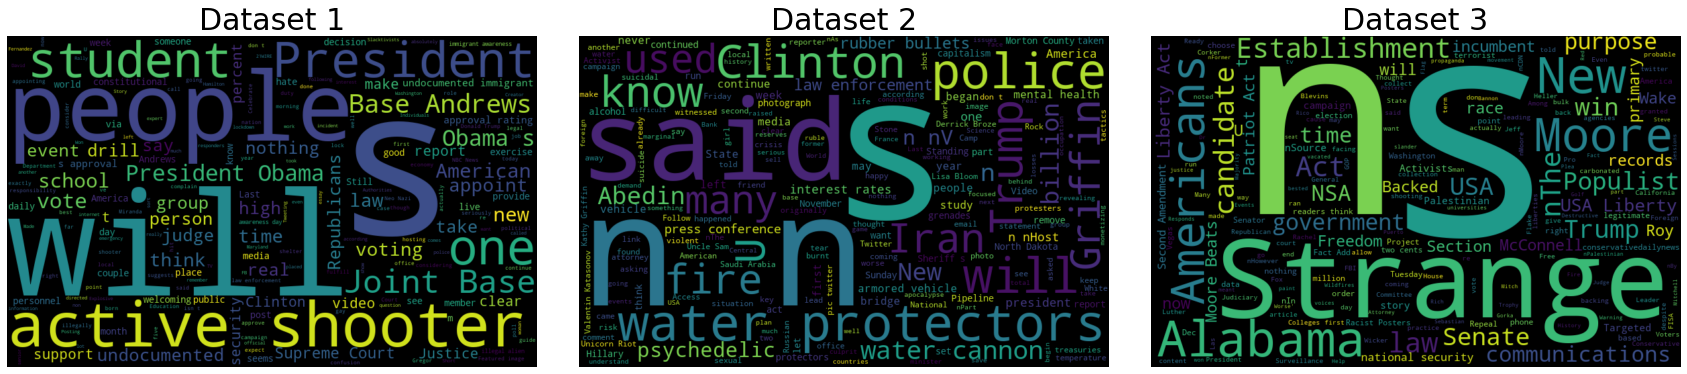

In [15]:
fig = plt.figure(figsize=(24,5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Dataset 1',fontsize=30)
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black').generate(str(DS1_final_df[ DS1_final_df['label']==1 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('Dataset 2',fontsize=30)
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black').generate(str(DS2_final_df[ DS2_final_df['label']==1 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('Dataset 3',fontsize=30)
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black').generate(str(DS3_final_df[ DS3_final_df['label']==1 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

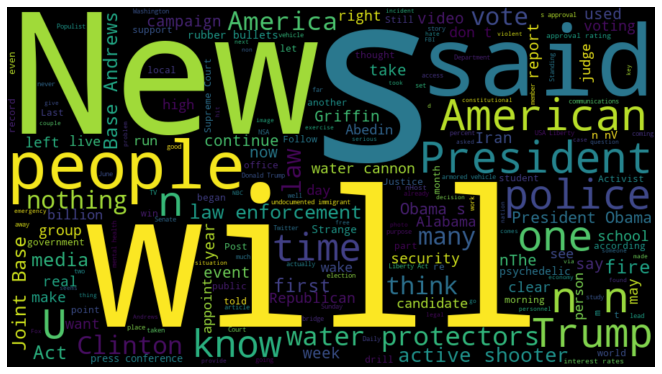

In [16]:
fig = plt.figure(figsize=(20,5))

wordcloud = WordCloud(width = 900, height = 500, background_color = 'black').generate(str(DS1_final_df[ DS1_final_df['label']==1 ]['text'].values)+str(DS2_final_df[ DS2_final_df['label']==1 ]['text'].values)+str(DS3_final_df[ DS3_final_df['label']==1 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

plt.axis('off')
plt.show()

### 2.2.2 Word Cloud for real news

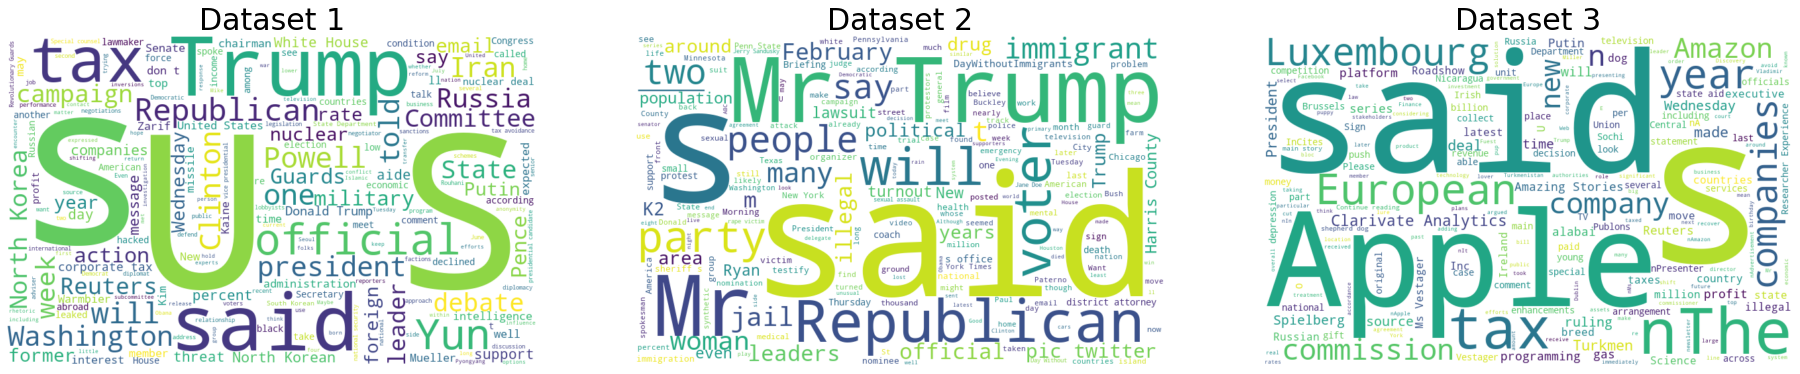

In [17]:
fig = plt.figure(figsize=(27,5), edgecolor = 'k')

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Dataset 1',fontsize=30)
wordcloud = WordCloud(width = 800, height = 500, background_color = 'white').generate(str(DS1_final_df[ DS1_final_df['label']==0 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('Dataset 2',fontsize=30)
wordcloud = WordCloud(width = 800, height = 500, background_color = 'white').generate(str(DS2_final_df[ DS2_final_df['label']==0 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('Dataset 3',fontsize=30)
wordcloud = WordCloud(width = 800, height = 500, background_color = 'white').generate(str(DS3_final_df[ DS3_final_df['label']==0 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

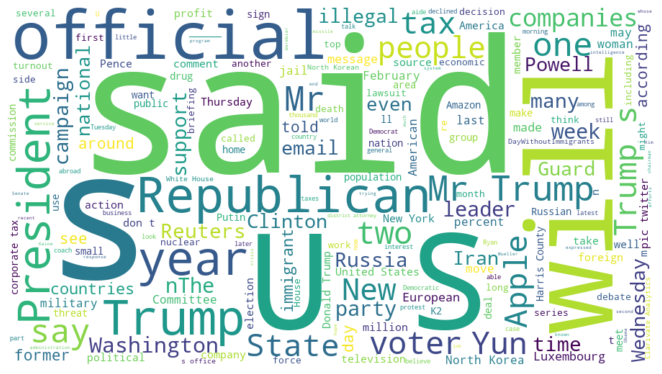

In [18]:
fig = plt.figure(figsize=(20,5))

wordcloud = WordCloud(width = 900, height = 500, background_color = 'white').generate(str(DS1_final_df[ DS1_final_df['label']==0 ]['text'].values)+str(DS2_final_df[ DS2_final_df['label']==0 ]['text'].values)+str(DS3_final_df[ DS3_final_df['label']==0 ]['text'].values))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

plt.axis('off')
plt.show()

## 2.3 Distribution of true and fake news

### 2.3.1 Dataset 1

In [19]:
sorted_counts = DS1_df['label'].value_counts(normalize=True)
sorted_counts_new = sorted_counts.copy()
sorted_counts_new[0] = sorted_counts[1]
sorted_counts_new[1] = sorted_counts[0]
sorted_counts_new.index=['0','1']
label_str = ['True','Fake'] 

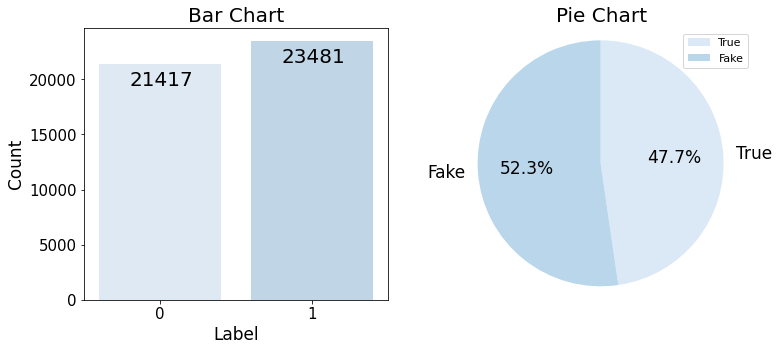

In [20]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
sns.countplot(DS1_df['label'],palette=sns.color_palette('Blues'))
ax1.set_title('Bar Chart',fontsize=20)
ax1.set_xlabel('Label',fontsize=17)
ax1.set_ylabel('Count',fontsize=17)
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()-2000), color='black', size=20)
    
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Pie Chart',fontsize=20)
plt.pie(sorted_counts_new, labels = label_str, textprops={'fontsize': 17},startangle = 90, counterclock = False,autopct="%1.1f%%",colors=sns.color_palette('Blues'));
plt.axis('equal')
plt.legend(fontsize=11)

plt.show()

In [21]:
DS1_df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

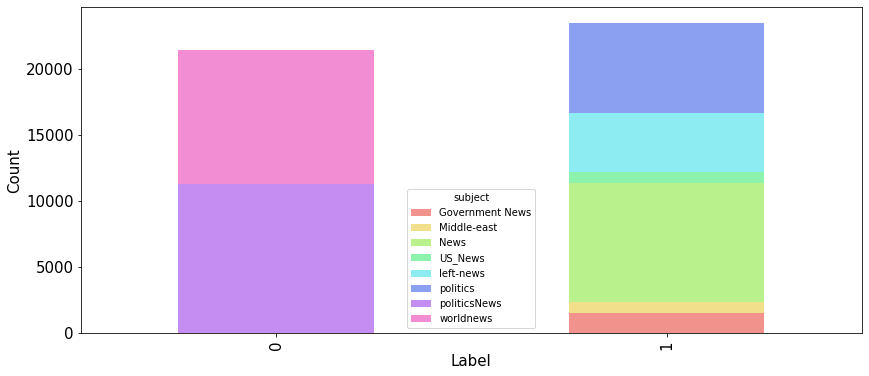

In [22]:
stacked_chart = pd.crosstab(DS1_df['label'], DS1_df['subject'])
stacked_chart.plot(kind='bar', stacked=True,figsize=(14,6),color=sns.hls_palette(8 , l = .75, s = .8))
plt.xlabel('Label',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 2.3.2 Dataset 2

In [23]:
author_df = DS2_df['author'].value_counts().rename_axis('author').reset_index(name='counts')

In [24]:
author_list = list(author_df[author_df['counts']>=100]['author'])

In [25]:
DS2_author_df = DS2_df[DS2_df['author'].isin(author_list)]

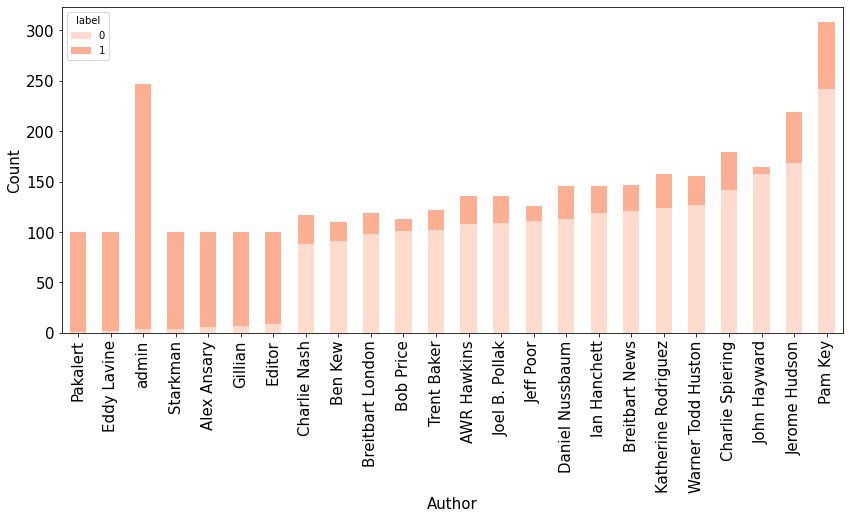

In [26]:
stacked_chart = pd.crosstab(DS2_author_df['author'],DS2_author_df['label']).sort_values(by=0)
stacked_chart.plot(kind='bar', stacked=True,figsize=(14,6),color=sns.color_palette('Reds'))
plt.xlabel('Author',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [27]:
sorted_counts = DS2_final_df['label'].value_counts(normalize=True)
sorted_counts_new = sorted_counts.copy()
sorted_counts_new[0] = sorted_counts[1]
sorted_counts_new[1] = sorted_counts[0]
sorted_counts_new.index=['1','0']
label_str = ['Fake','True'] 

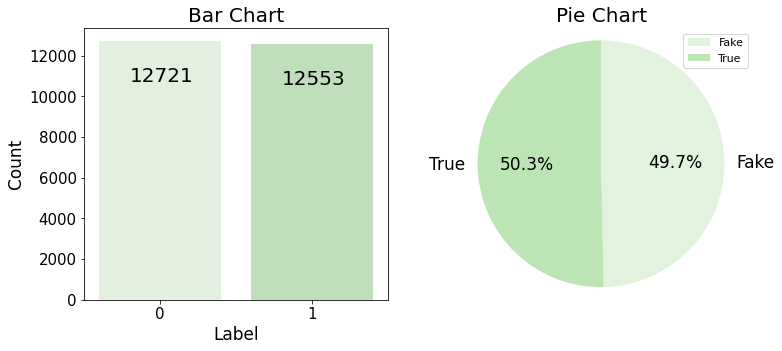

In [28]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
sns.countplot(DS2_final_df['label'],palette=sns.color_palette('Greens'))
ax1.set_title('Bar Chart',fontsize=20)
ax1.set_xlabel('Label',fontsize=17)
ax1.set_ylabel('Count',fontsize=17)
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()-2000), color='black', size=20)
    
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Pie Chart',fontsize=20)
plt.pie(sorted_counts_new, labels = label_str, textprops={'fontsize': 17},startangle = 90, counterclock = False,autopct="%1.1f%%",colors=sns.color_palette('Greens'));
plt.axis('equal')
plt.legend(fontsize=11)

plt.show()

## 2.3 Dataset 3

In [29]:
DS3_final_df['label'].value_counts(ascending=True).rename_axis('label').reset_index(name='counts')

,label,counts
0,0,1868
1,1,2120


In [30]:
sorted_counts = DS3_final_df['label'].value_counts(normalize=True)
sorted_counts_new = sorted_counts.copy()
sorted_counts_new[0] = sorted_counts[1]
sorted_counts_new[1] = sorted_counts[0]
sorted_counts_new.index=['0','1']
label_str = ['True','Fake'] 

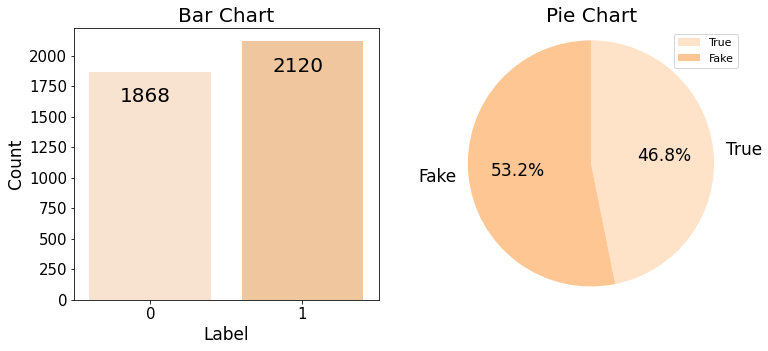

In [31]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
sns.countplot(DS3_final_df['label'],palette=sns.color_palette('Oranges'))
ax1.set_title('Bar Chart',fontsize=20)
ax1.set_xlabel('Label',fontsize=17)
ax1.set_ylabel('Count',fontsize=17)
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()-250), color='black', size=20)
    
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Pie Chart',fontsize=20)
plt.pie(sorted_counts_new, labels = label_str, textprops={'fontsize': 17},startangle = 90, counterclock = False,autopct="%1.1f%%",colors=sns.color_palette('Oranges'));
plt.axis('equal')
plt.legend(fontsize=11)

plt.show()

# 3. Text Pre-processing

- Lowercase
- Punctuation Remove
- Tokenization
- Lemmatization
- Stopwords Remove
- Stemming

In [32]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luyuh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luyuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luyuh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\luyuh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\luyuh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 3.1 Example of a piece of news

In [33]:
news = DS1_final_df['text'][0]

print(news)

### 3.1.1 Lowercase

In [34]:
lower_text = news.lower()

print(lower_text)

### 3.1.2 Punctuation Remove

In [35]:
without_punctuation = " ".join(re.findall(r'\b\w+\b',lower_text))

print(without_punctuation)

### 3.1.3 Tokenization

In [36]:
tokenize = word_tokenize(without_punctuation)

print(tokenize)

### 3.1.4 Lemmatization

In [37]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [38]:
tagged_sent = nltk.pos_tag(tokenize)
lem_text = [ WordNetLemmatizer().lemmatize(tag[0], pos=get_wordnet_pos(tag[1]) or wordnet.NOUN) for tag in tagged_sent]

print(lem_text)

### 3.1.5 Stopwords Remove

In [39]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [40]:
without_stopwords = [w for w in lem_text if not w in stopwords] 

print(without_stopwords)

### 3.1.6 Stemming

In [41]:
stem_text=[SnowballStemmer('english').stem(word) for word in without_stopwords]

print(stem_text)

## 3.2 Process the whole dataset

In [42]:
def list_txt(path, list=None):
    if list != None:
        file = open(path, 'w', encoding='utf-8')
        file.write(str(list))
        file.close()
        return None
    else:
        file = open(path, 'r', encoding='utf-8')
        rdlist = eval(file.read())
        file.close()
        return rdlist

In [43]:
DS1_corpus = []
DS2_corpus = []
DS3_corpus = []

In [44]:
@profile_1
def corpus(df, corpus, n):
    for i in range(0, df.shape[0]):
        news = df['text'][i]
        lower_text = news.lower()
        without_punctuation = " ".join(re.findall(r'\b\w+\b',lower_text))
        tokenize = word_tokenize(without_punctuation)
        tagged_sent = nltk.pos_tag(tokenize)
        lem_text = [ WordNetLemmatizer().lemmatize(tag[0], pos=get_wordnet_pos(tag[1]) or wordnet.NOUN) for tag in tagged_sent]
        without_stopwords = [w for w in lem_text if not w in stopwords] 
        stem_text = [SnowballStemmer('english').stem(word) for word in without_stopwords]
        corpus.append(' '.join(stem_text))
    list_txt("corpus_"+n,corpus)

In [45]:
DS1_final_df.to_csv("./DS1_final_df.csv",index=None) 
DS2_final_df.to_csv("./DS2_final_df.csv",index=None) 
DS3_final_df.to_csv("./DS3_final_df.csv",index=None) 

### 3.2.1 Dataset 1

In [46]:
time_1, mem_1 = corpus(DS1_final_df, DS1_corpus, "1")

Running Memory: 66.03 MB
Running Time: 1489.02 Seconds


### 3.2.2 Dataset 2

In [47]:
time_2, mem_2 = corpus(DS2_final_df, DS2_corpus, "2")

Running Memory: 75.35 MB
Running Time: 1683.91 Seconds


### 3.2.3 Dataset 3

In [48]:
time_3, mem_3 = corpus(DS3_final_df, DS3_corpus, "3")

Running Memory: 8.90 MB
Running Time: 242.84 Seconds


In [50]:
DS_time  = [time_1,time_2,time_3]
DS_mem   = [mem_1, mem_2, mem_3]
corpus_time_mem_df =  pd.DataFrame()
corpus_time_mem_df['Time (S)']    = DS_time
corpus_time_mem_df['Memory (MB)'] = DS_mem
corpus_time_mem_df.index = ['Corpus1','Corpus2','Corpus3']
corpus_time_mem_df

# 4. Feature Extraction

In [52]:
#DS1_corpus = list_txt('corpus_1')

In [53]:
#DS2_corpus = list_txt('corpus_2')

In [54]:
#DS3_corpus = list_txt('corpus_3')

## Bag of words + N-gram (N=1,2)&emsp;/&emsp;TF-IDF + N-gram (N=1,2)

In [55]:
@profile_2
def feature_extraction(df,corpus,method,n):
    
    if method=='bow':
        if n==1 or n==2 or n==3 or n==4:
            vectorizer = CountVectorizer(max_features = 40, ngram_range=(n,n))
            x = vectorizer.fit_transform(corpus).toarray()
            y = df.iloc[0:df.shape[0], 1].values
            feature_df = pd.DataFrame(x, columns=vectorizer.get_feature_names_out())
            return x,y,vectorizer,feature_df
        else: 
            return print('N is wrong!')
        
    elif method=='tf-idf':
        if n==1 or n==2 or n==3 or n==4:
            vectorizer = TfidfVectorizer(max_features = 40, ngram_range=(n,n))
            x = vectorizer.fit_transform(corpus).toarray()
            y = df.iloc[0:df.shape[0], 1].values
            feature_df = pd.DataFrame(x, columns=vectorizer.get_feature_names_out())
            return x,y,vectorizer,feature_df
        else: 
            return print('N is wrong!')
    else: return print('Wrong!')

## 4.1 Dataset 1

In [54]:
DS1_bow_1_res, DS1_bow_1_time, DS1_bow_1_mem = feature_extraction(DS1_final_df,DS1_corpus,'bow',1)

DS1_bow_1_x = DS1_bow_1_res[0]
DS1_bow_1_y = DS1_bow_1_res[1]
DS1_bow_1_vectorizer = DS1_bow_1_res[2]
DS1_bow_1_feature_df = DS1_bow_1_res[3]

Running Memory: 34.61 MB
Running Time: 8.98 Seconds


In [55]:
DS1_bow_2_res, DS1_bow_2_time, DS1_bow_2_mem = feature_extraction(DS1_final_df,DS1_corpus,'bow',2)

DS1_bow_2_x = DS1_bow_2_res[0]
DS1_bow_2_y = DS1_bow_2_res[1]
DS1_bow_2_vectorizer = DS1_bow_2_res[2]
DS1_bow_2_feature_df = DS1_bow_2_res[3]

Running Memory: 588.42 MB
Running Time: 32.09 Seconds


In [56]:
DS1_bow_3_res, DS1_bow_3_time, DS1_bow_3_mem = feature_extraction(DS1_final_df,DS1_corpus,'bow',3)

DS1_bow_3_x = DS1_bow_3_res[0]
DS1_bow_3_y = DS1_bow_3_res[1]
DS1_bow_3_vectorizer = DS1_bow_3_res[2]
DS1_bow_3_feature_df = DS1_bow_3_res[3]

Running Memory: 17.11 MB
Running Time: 58.54 Seconds


In [57]:
DS1_tfidf_1_res, DS1_tfidf_1_time, DS1_tfidf_1_mem = feature_extraction(DS1_final_df,DS1_corpus,'tf-idf',1)

DS1_tfidf_1_x = DS1_tfidf_1_res[0]
DS1_tfidf_1_y = DS1_tfidf_1_res[1]
DS1_tfidf_1_vectorizer = DS1_tfidf_1_res[2]
DS1_tfidf_1_feature_df = DS1_tfidf_1_res[3]

Running Memory: 51.14 MB
Running Time: 8.65 Seconds


In [58]:
DS1_tfidf_2_res, DS1_tfidf_2_time, DS1_tfidf_2_mem = feature_extraction(DS1_final_df,DS1_corpus,'tf-idf',2)

DS1_tfidf_2_x = DS1_tfidf_2_res[0]
DS1_tfidf_2_y = DS1_tfidf_2_res[1]
DS1_tfidf_2_vectorizer = DS1_tfidf_2_res[2]
DS1_tfidf_2_feature_df = DS1_tfidf_2_res[3]

Running Memory: 379.05 MB
Running Time: 32.46 Seconds


In [59]:
DS1_tfidf_3_res, DS1_tfidf_3_time, DS1_tfidf_3_mem = feature_extraction(DS1_final_df,DS1_corpus,'tf-idf',3)

DS1_tfidf_3_x = DS1_tfidf_3_res[0]
DS1_tfidf_3_y = DS1_tfidf_3_res[1]
DS1_tfidf_3_vectorizer = DS1_tfidf_3_res[2]
DS1_tfidf_3_feature_df = DS1_tfidf_3_res[3]

Running Memory: 212.97 MB
Running Time: 59.12 Seconds


In [60]:
DS1_feature_mem  = [DS1_bow_1_mem, DS1_bow_2_mem, DS1_bow_3_mem, DS1_tfidf_1_mem,  DS1_tfidf_2_mem,  DS1_tfidf_3_mem]
DS1_feature_time = [DS1_bow_1_time, DS1_bow_2_time, DS1_bow_3_time, DS1_tfidf_1_time, DS1_tfidf_2_time, DS1_tfidf_3_time]

this_df_1 = pd.DataFrame()
this_df_1['Time (S)']=DS1_feature_time
this_df_1['Memory (MB)']=DS1_feature_mem
this_df_1.index=['BoW(n=1)','BoW(n=2)','BoW(n=3)','TF-IDF(n=1)','TF-IDF(n=2)','TF-IDF(n=3)']

In [61]:
this_df_1.round(2)

,Time (S),Memory (MB)
BoW(n=1),8.98,34.61
BoW(n=2),32.09,588.42
BoW(n=3),58.54,17.11
TF-IDF(n=1),8.65,51.14
TF-IDF(n=2),32.46,379.05
TF-IDF(n=3),59.12,212.97


In [62]:
# DS1_feature_mem  = [35.61, 473.71, 594.45, 42.64, 388.32, 564.30]
# DS1_feature_time = [10.21, 32.42, 59.01, 10.17, 35.32, 58.63]

# here_df_1 = pd.DataFrame()
# here_df_1['Time (S)']=DS1_feature_time
# here_df_1['Memory (MB)']=DS1_feature_mem
# here_df_1.index=['BoW(n=1)','BoW(n=2)','BoW(n=3)','TF-IDF(n=1)','TF-IDF(n=2)','TF-IDF(n=3)']
# here_df_1

In [63]:
def show_features(df, color, n, a, b, s):
    features_name_list  = list(df.columns)
    
    features_num_list   = []
    for i in features_name_list:
        features_num_list.append(max(df[i]))
        
    features_final_dict = {}
    for i in range(0,len(features_name_list)):
        features_final_dict[features_name_list[i]]=features_num_list[i]

    features_final_dict = sorted(features_final_dict.items(), key=lambda x: x[1], reverse=False)

    features_final_name_list = []
    features_final_num_list = []
    
    for i in features_final_dict:
        features_final_name_list.append(i[0])
        features_final_num_list.append(i[1])
    
    fig = plt.figure(figsize=(a,b))
    plt.barh(features_final_name_list[40-n:], features_final_num_list[40-n:], height=0.4,color=sns.color_palette(color,n), edgecolor='black')
    plt.xlabel(s,fontsize=20)
    plt.ylabel('Feature',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [64]:
#show_features(DS1_bow_1_feature_df, 'Blues', 15, 6, 6, 'Count')

In [65]:
#show_features(DS1_bow_2_feature_df, 'Blues', 15, 6, 6, 'Count')

In [66]:
#show_features(DS1_bow_3_feature_df, 'Blues', 15, 3, 6, 'Count')

In [67]:
#show_features(DS1_tfidf_1_feature_df, 'Oranges', 15, 6, 6, 'Score')

In [68]:
#show_features(DS1_tfidf_2_feature_df, 'Oranges', 15, 6, 6, 'Score')

In [69]:
#show_features(DS1_tfidf_3_feature_df, 'Oranges', 15, 3, 6, 'Score')

## 4.2 Dataset 2

In [70]:
DS2_bow_1_res, DS2_bow_1_time, DS2_bow_1_mem = feature_extraction(DS2_final_df,DS2_corpus,'bow',1)

DS2_bow_1_x = DS2_bow_1_res[0]
DS2_bow_1_y = DS2_bow_1_res[1]
DS2_bow_1_vectorizer = DS2_bow_1_res[2]
DS2_bow_1_feature_df = DS2_bow_1_res[3]

Running Memory: 103.29 MB
Running Time: 10.61 Seconds


In [71]:
DS2_bow_2_res, DS2_bow_2_time, DS2_bow_2_mem = feature_extraction(DS2_final_df,DS2_corpus,'bow',2)

DS2_bow_2_x = DS2_bow_2_res[0]
DS2_bow_2_y = DS2_bow_2_res[1]
DS2_bow_2_vectorizer = DS2_bow_2_res[2]
DS2_bow_2_feature_df = DS2_bow_2_res[3]

Running Memory: 394.03 MB
Running Time: 40.48 Seconds


In [72]:
DS2_bow_3_res, DS2_bow_3_time, DS2_bow_3_mem = feature_extraction(DS2_final_df,DS2_corpus,'bow',3)

DS2_bow_3_x = DS2_bow_3_res[0]
DS2_bow_3_y = DS2_bow_3_res[1]
DS2_bow_3_vectorizer = DS2_bow_3_res[2]
DS2_bow_3_feature_df = DS2_bow_3_res[3]

Running Memory: 816.90 MB
Running Time: 69.56 Seconds


In [73]:
DS2_tfidf_1_res, DS2_tfidf_1_time, DS2_tfidf_1_mem = feature_extraction(DS2_final_df,DS2_corpus,'tf-idf',1)

DS2_tfidf_1_x = DS2_tfidf_1_res[0]
DS2_tfidf_1_y = DS2_tfidf_1_res[1]
DS2_tfidf_1_vectorizer = DS2_tfidf_1_res[2]
DS2_tfidf_1_feature_df = DS2_tfidf_1_res[3]

Running Memory: 96.49 MB
Running Time: 9.27 Seconds


In [74]:
DS2_tfidf_2_res, DS2_tfidf_2_time, DS2_tfidf_2_mem = feature_extraction(DS2_final_df,DS2_corpus,'tf-idf',2)

DS2_tfidf_2_x = DS2_tfidf_2_res[0]
DS2_tfidf_2_y = DS2_tfidf_2_res[1]
DS2_tfidf_2_vectorizer = DS2_tfidf_2_res[2]
DS2_tfidf_2_feature_df = DS2_tfidf_2_res[3]

Running Memory: 326.21 MB
Running Time: 39.68 Seconds


In [76]:
DS2_tfidf_3_res, DS2_tfidf_3_time, DS2_tfidf_3_mem = feature_extraction(DS2_final_df,DS2_corpus,'tf-idf',3)

DS2_tfidf_3_x = DS2_tfidf_3_res[0]
DS2_tfidf_3_y = DS2_tfidf_3_res[1]
DS2_tfidf_3_vectorizer = DS2_tfidf_3_res[2]
DS2_tfidf_3_feature_df = DS2_tfidf_3_res[3]

MemoryError: 

In [ ]:
# DS2_feature_mem  = [DS2_bow_1_mem, DS2_bow_2_mem, DS2_bow_3_mem, DS2_tfidf_1_mem,  DS2_tfidf_2_mem,  DS2_tfidf_3_mem]
# DS2_feature_time = [DS2_bow_1_time, DS2_bow_2_time, DS2_bow_3_time, DS2_tfidf_1_time, DS2_tfidf_2_time, DS2_tfidf_3_time]

# this_df_2 = pd.DataFrame()
# this_df_2['Time (S)']    = DS2_feature_time
# this_df_2['Memory (MB)'] = DS2_feature_mem
# this_df_2.index = ['BoW(n=1)','BoW(n=2)','BoW(n=3)','TF-IDF(n=1)','TF-IDF(n=2)','TF-IDF(n=3)']

In [ ]:
# DS2_feature_mem  = [102.51, 265.97, 994.67, 81.50, 372.50, 477.73]
# DS2_feature_time = [23.50, 69.33, 101.81, 13.83, 59.08, 101.57]

# here_df_2 = pd.DataFrame()
# here_df_2['Time (S)']    = DS2_feature_time
# here_df_2['Memory (MB)'] = DS2_feature_mem
# here_df_2.index=['BoW(n=1)','BoW(n=2)','BoW(n=3)','TF-IDF(n=1)','TF-IDF(n=2)','TF-IDF(n=3)']
# here_df_2

In [ ]:
#show_features(DS2_bow_1_feature_df, 'Blues', 15, 6, 6)

In [ ]:
#show_features(DS2_bow_2_feature_df, 'Blues', 15, 6, 6)

In [ ]:
#show_features(DS2_bow_3_feature_df, 'Blues', 15, 8, 6)

In [ ]:
#show_features(DS2_tfidf_1_feature_df, 'Oranges', 15, 6, 6)

In [ ]:
#show_features(DS2_tfidf_2_feature_df, 'Oranges', 15, 6, 6)

In [ ]:
#show_features(DS2_tfidf_3_feature_df, 'Oranges', 15, 8, 6)

## 4.3 Dataset 3

In [56]:
DS3_bow_1_res, DS3_bow_1_time, DS3_bow_1_mem = feature_extraction(DS3_final_df,DS3_corpus,'bow',1)

DS3_bow_1_x = DS3_bow_1_res[0]
DS3_bow_1_y = DS3_bow_1_res[1]
DS3_bow_1_vectorizer = DS3_bow_1_res[2]
DS3_bow_1_feature_df = DS3_bow_1_res[3]

Running Memory: 10.16 MB
Running Time: 1.14 Seconds


In [57]:
DS3_bow_2_res, DS3_bow_2_time, DS3_bow_2_mem = feature_extraction(DS3_final_df,DS3_corpus,'bow',2)

DS3_bow_2_x = DS3_bow_2_res[0]
DS3_bow_2_y = DS3_bow_2_res[1]
DS3_bow_2_vectorizer = DS3_bow_2_res[2]
DS3_bow_2_feature_df = DS3_bow_2_res[3]

Running Memory: 88.18 MB
Running Time: 4.11 Seconds


In [58]:
DS3_bow_3_res, DS3_bow_3_time, DS3_bow_3_mem = feature_extraction(DS3_final_df,DS3_corpus,'bow',3)

DS3_bow_3_x = DS3_bow_3_res[0]
DS3_bow_3_y = DS3_bow_3_res[1]
DS3_bow_3_vectorizer = DS3_bow_3_res[2]
DS3_bow_3_feature_df = DS3_bow_3_res[3]

Running Memory: 138.47 MB
Running Time: 5.18 Seconds


In [59]:
DS3_tfidf_1_res, DS3_tfidf_1_time, DS3_tfidf_1_mem = feature_extraction(DS3_final_df,DS3_corpus,'tf-idf',1)

DS3_tfidf_1_x = DS3_tfidf_1_res[0]
DS3_tfidf_1_y = DS3_tfidf_1_res[1]
DS3_tfidf_1_vectorizer = DS3_tfidf_1_res[2]
DS3_tfidf_1_feature_df = DS3_tfidf_1_res[3]

Running Memory: 4.48 MB
Running Time: 1.13 Seconds


In [60]:
DS3_tfidf_2_res, DS3_tfidf_2_time, DS3_tfidf_2_mem = feature_extraction(DS3_final_df,DS3_corpus,'tf-idf',2)

DS3_tfidf_2_x = DS3_tfidf_2_res[0]
DS3_tfidf_2_y = DS3_tfidf_2_res[1]
DS3_tfidf_2_vectorizer = DS3_tfidf_2_res[2]
DS3_tfidf_2_feature_df = DS3_tfidf_2_res[3]

Running Memory: 67.73 MB
Running Time: 4.45 Seconds


In [61]:
DS3_tfidf_3_res, DS3_tfidf_3_time, DS3_tfidf_3_mem = feature_extraction(DS3_final_df,DS3_corpus,'tf-idf',3)

DS3_tfidf_3_x = DS3_tfidf_3_res[0]
DS3_tfidf_3_y = DS3_tfidf_3_res[1]
DS3_tfidf_3_vectorizer = DS3_tfidf_3_res[2]
DS3_tfidf_3_feature_df = DS3_tfidf_3_res[3]

Running Memory: 138.71 MB
Running Time: 4.95 Seconds


In [62]:
DS3_feature_mem  = [DS3_bow_1_mem, DS3_bow_2_mem, DS3_bow_3_mem, DS3_tfidf_1_mem,  DS3_tfidf_2_mem,  DS3_tfidf_3_mem]
DS3_feature_time = [DS3_bow_1_time, DS3_bow_2_time, DS3_bow_3_time, DS3_tfidf_1_time, DS3_tfidf_2_time, DS3_tfidf_3_time]

this_df_3 = pd.DataFrame()
this_df_3['Time (S)'] = DS3_feature_time
this_df_3['Memory (MB)'] = DS3_feature_mem
this_df_3.index = ['BoW(n=1)','BoW(n=2)','BoW(n=3)','TF-IDF(n=1)','TF-IDF(n=2)','TF-IDF(n=3)']
this_df_3.round(2)

,Time (S),Memory (MB)
BoW(n=1),1.14,10.16
BoW(n=2),4.11,88.18
BoW(n=3),5.18,138.47
TF-IDF(n=1),1.13,4.48
TF-IDF(n=2),4.45,67.73
TF-IDF(n=3),4.95,138.71


In [ ]:
# DS3_feature_mem  = [13.45, 37.23, 73.23, 4.49, 37.23, 48.18]
# DS3_feature_time = [2.88, 5.71, 8.81, 1.62, 6.07, 6.79]

# here_df_3 = pd.DataFrame()
# here_df_3['Time (S)']    = DS3_feature_time
# here_df_3['Memory (MB)'] = DS3_feature_mem
# here_df_3.index=['BoW(n=1)','BoW(n=2)','BoW(n=3)','TF-IDF(n=1)','TF-IDF(n=2)','TF-IDF(n=3)']
# here_df_3

In [ ]:
#show_features(DS3_bow_1_feature_df, 'Blues', 25, 6, 6, 'Count')

In [ ]:
#show_features(DS3_bow_2_feature_df, 'Blues', 15, 6, 6)

In [ ]:
#show_features(DS3_bow_3_feature_df, 'Blues', 15, 8, 6)

In [ ]:
#show_features(DS3_tfidf_1_feature_df, 'Oranges', 15, 6, 6)

In [ ]:
#show_features(DS3_tfidf_2_feature_df, 'Oranges', 15, 6, 6)

In [ ]:
#show_features(DS3_tfidf_3_feature_df, 'Oranges', 15, 8, 6)

# 5. Data Split

In [63]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 20)
    return x_train, x_test, y_train, y_test

## 5.1 Dataset 1 

In [ ]:
DS1_bow_1_x_train, DS1_bow_1_x_test, DS1_bow_1_y_train, DS1_bow_1_y_test = split(DS1_bow_1_x,DS1_bow_1_y)
DS1_bow_2_x_train, DS1_bow_2_x_test, DS1_bow_2_y_train, DS1_bow_2_y_test = split(DS1_bow_2_x,DS1_bow_2_y)
DS1_bow_3_x_train, DS1_bow_3_x_test, DS1_bow_3_y_train, DS1_bow_3_y_test = split(DS1_bow_3_x,DS1_bow_3_y)
DS1_tfidf_1_x_train, DS1_tfidf_1_x_test, DS1_tfidf_1_y_train, DS1_tfidf_1_y_test = split(DS1_tfidf_1_x,DS1_tfidf_1_y)
DS1_tfidf_2_x_train, DS1_tfidf_2_x_test, DS1_tfidf_2_y_train, DS1_tfidf_2_y_test = split(DS1_tfidf_2_x,DS1_tfidf_2_y)
DS1_tfidf_3_x_train, DS1_tfidf_3_x_test, DS1_tfidf_3_y_train, DS1_tfidf_3_y_test = split(DS1_tfidf_3_x,DS1_tfidf_3_y)

## 5.2 Dataset 2

In [ ]:
DS2_bow_1_x_train, DS2_bow_1_x_test, DS2_bow_1_y_train, DS2_bow_1_y_test = split(DS2_bow_1_x,DS2_bow_1_y)
DS2_bow_2_x_train, DS2_bow_2_x_test, DS2_bow_2_y_train, DS2_bow_2_y_test = split(DS2_bow_2_x,DS2_bow_2_y)
DS2_bow_3_x_train, DS2_bow_3_x_test, DS2_bow_3_y_train, DS2_bow_3_y_test = split(DS2_bow_3_x,DS2_bow_3_y)
DS2_tfidf_1_x_train, DS2_tfidf_1_x_test, DS2_tfidf_1_y_train, DS2_tfidf_1_y_test = split(DS2_tfidf_1_x,DS2_tfidf_1_y)
DS2_tfidf_2_x_train, DS2_tfidf_2_x_test, DS2_tfidf_2_y_train, DS2_tfidf_2_y_test = split(DS2_tfidf_2_x,DS2_tfidf_2_y)
#DS2_tfidf_3_x_train, DS2_tfidf_3_x_test, DS2_tfidf_3_y_train, DS2_tfidf_3_y_test = split(DS2_tfidf_3_x,DS2_tfidf_3_y)

In [ ]:
DS2_bow_1_x_train, DS2_bow_1_x_test, DS2_bow_1_y_train, DS2_bow_1_y_test = split(DS2_bow_1_x,DS2_bow_1_y)
DS2_bow_2_x_train, DS2_bow_2_x_test, DS2_bow_2_y_train, DS2_bow_2_y_test = split(DS2_bow_2_x,DS2_bow_2_y)
DS2_bow_3_x_train, DS2_bow_3_x_test, DS2_bow_3_y_train, DS2_bow_3_y_test = split(DS2_bow_3_x,DS2_bow_3_y)
DS2_tfidf_1_x_train, DS2_tfidf_1_x_test, DS2_tfidf_1_y_train, DS2_tfidf_1_y_test = split(DS2_tfidf_1_x,DS2_tfidf_1_y)
DS2_tfidf_2_x_train, DS2_tfidf_2_x_test, DS2_tfidf_2_y_train, DS2_tfidf_2_y_test = split(DS2_tfidf_2_x,DS2_tfidf_2_y)
DS2_tfidf_3_x_train, DS2_tfidf_3_x_test, DS2_tfidf_3_y_train, DS2_tfidf_3_y_test = split(DS2_tfidf_3_x,DS2_tfidf_3_y)

## 5.3 Dataset 3

In [64]:
DS3_bow_1_x_train, DS3_bow_1_x_test, DS3_bow_1_y_train, DS3_bow_1_y_test = split(DS3_bow_1_x,DS3_bow_1_y)
DS3_bow_2_x_train, DS3_bow_2_x_test, DS3_bow_2_y_train, DS3_bow_2_y_test = split(DS3_bow_2_x,DS3_bow_2_y)
DS3_bow_3_x_train, DS3_bow_3_x_test, DS3_bow_3_y_train, DS3_bow_3_y_test = split(DS3_bow_3_x,DS3_bow_3_y)
DS3_tfidf_1_x_train, DS3_tfidf_1_x_test, DS3_tfidf_1_y_train, DS3_tfidf_1_y_test = split(DS3_tfidf_1_x,DS3_tfidf_1_y)
DS3_tfidf_2_x_train, DS3_tfidf_2_x_test, DS3_tfidf_2_y_train, DS3_tfidf_2_y_test = split(DS3_tfidf_2_x,DS3_tfidf_2_y)
DS3_tfidf_3_x_train, DS3_tfidf_3_x_test, DS3_tfidf_3_y_train, DS3_tfidf_3_y_test = split(DS3_tfidf_3_x,DS3_tfidf_3_y)

In [65]:
SKF = StratifiedKFold(n_splits=10, random_state=20, shuffle=True)

# 6. Train and Predict

In [66]:
@profile_1
def train(x_train, y_train, classifier, SKF):
    model  = classifier.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=SKF) 
    print("Train Accuracy: %.4f" % (np.mean(scores)))    

In [67]:
def predict(x_test, y_test, classifier):
    y_pred = classifier.predict(x_test)
   
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Test  Accuracy: %.4f" % acc)
    print("Test  Presion:  %.4f" % pre)
    print("Test  Recall:   %.4f" % rec)
    print("Test  F1-score: %.4f" % f1)
    return cm, acc, pre, rec, f1

In [68]:
def show_confusion_maxtrix(cm, model, method):
    new_cm = pd.DataFrame(cm)
    ax = sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='', annot_kws={"fontsize":14})
    plt.xlabel("Actual",fontsize=14)
    plt.ylabel("Predicted",fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    plt.title('Confusion matrix: '+ model+method,fontsize=15)
    plt.show()

In [69]:
model_1  = ' LR'
model_2  = ' LSVM'
model_3  = ' MLP'
model_4  = ' KNN'
model_5  = ' RF'
model_6  = ' Voting 1' #(RF, LR, KNN)
model_7  = ' Voting 2' #(LR, LSVM, CART)
model_8  = ' Bagging'
model_9  = ' AdaBoost'
model_10 = ' XGBoost'

method_1 = ' (BoW) (n=1)'
method_2 = ' (BoW) (n=2)'
method_3 = ' (BoW) (n=3)'
method_4 = ' (TF-IDF) (n=1)'
method_5 = ' (TF-IDF) (n=2)'
method_6 = ' (TF-IDF) (n=3)'

In [70]:
classifier_LR = LogisticRegression(random_state=20)

In [71]:
classifier_LSVM = LinearSVC()

In [72]:
classifier_MLP = MLPClassifier(solver='sgd', activation='relu', alpha=1e-4, hidden_layer_sizes=(50, 50), random_state=20,
                    max_iter=50, verbose=True, learning_rate_init=.1)

In [73]:
classifier_KNN = KNeighborsClassifier()

In [74]:
classifier_RF = RandomForestClassifier(random_state=20)

In [75]:
rf  =  RandomForestClassifier(random_state=20)
lr  =  LogisticRegression(random_state=20)
knn =  KNeighborsClassifier()
lsvm =  LinearSVC()
cart =  DecisionTreeClassifier(random_state=20)

classifier_VOT_1 = VotingClassifier(estimators=[('RF',rf), ('LR',lr), ('KNN',knn)],voting='hard')
classifier_VOT_2 = VotingClassifier(estimators=[ ('LR',lr), ('LSVM',lsvm), ('CART',cart)],voting='hard')

In [76]:
classifier_BAGG = BaggingClassifier(n_estimators=100, random_state=20)

In [77]:
classifier_ADA = AdaBoostClassifier(random_state=20)

In [78]:
classifier_XG = XGBClassifier(eval_metric=['logloss','auc','error'], random_state=20)

## 6.1 Dataset 1

### 6.1.1 Logic Regression

In [ ]:
time_LR_DS1_bow_1, memory_LR_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_LR, SKF)
cm_LR_DS1_bow_1, acc_LR_DS1_bow_1, pre_LR_DS1_bow_1, rec_LR_DS1_bow_1, f1_LR_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS1_bow_1, model_1, method_1)

In [ ]:
time_LR_DS1_bow_2, memory_LR_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_LR, SKF)
cm_LR_DS1_bow_2, acc_LR_DS1_bow_2, pre_LR_DS1_bow_2, rec_LR_DS1_bow_2, f1_LR_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS1_bow_2, model_1, method_2)

In [ ]:
time_LR_DS1_bow_3, memory_LR_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_LR, SKF)
cm_LR_DS1_bow_3, acc_LR_DS1_bow_3, pre_LR_DS1_bow_3, rec_LR_DS1_bow_3, f1_LR_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS1_bow_3, model_1, method_3)

In [ ]:
time_LR_DS1_tfidf_1, memory_LR_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_LR, SKF)
cm_LR_DS1_tfidf_1, acc_LR_DS1_tfidf_1, pre_LR_DS1_tfidf_1, rec_LR_DS1_tfidf_1, f1_LR_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS1_tfidf_1, model_1, method_4)

In [ ]:
time_LR_DS1_tfidf_2, memory_LR_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_LR, SKF)
cm_LR_DS1_tfidf_2, acc_LR_DS1_tfidf_2, pre_LR_DS1_tfidf_2, rec_LR_DS1_tfidf_2, f1_LR_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS1_tfidf_2, model_1, method_5)

In [ ]:
time_LR_DS1_tfidf_3, memory_LR_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_LR, SKF)
cm_LR_DS1_tfidf_3, acc_LR_DS1_tfidf_3, pre_LR_DS1_tfidf_3, rec_LR_DS1_tfidf_3, f1_LR_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS1_tfidf_3, model_1, method_6)

### 6.1.2 LSVM

In [ ]:
time_LSVM_DS1_bow_1, memory_LSVM_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_LSVM, SKF)
cm_LSVM_DS1_bow_1, acc_LSVM_DS1_bow_1, pre_LSVM_DS1_bow_1, rec_LSVM_DS1_bow_1, f1_LSVM_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS1_bow_1, model_2, method_1)

In [ ]:
time_LSVM_DS1_bow_2, memory_LSVM_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_LSVM, SKF)
cm_LSVM_DS1_bow_2, acc_LSVM_DS1_bow_2, pre_LSVM_DS1_bow_2, rec_LSVM_DS1_bow_2, f1_LSVM_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS1_bow_2, model_2, method_2)

In [ ]:
time_LSVM_DS1_bow_3, memory_LSVM_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_LSVM, SKF)
cm_LSVM_DS1_bow_3, acc_LSVM_DS1_bow_3, pre_LSVM_DS1_bow_3, rec_LSVM_DS1_bow_3, f1_LSVM_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS1_bow_3, model_2, method_3)

In [ ]:
time_LSVM_DS1_tfidf_1, memory_LSVM_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_LSVM, SKF)
cm_LSVM_DS1_tfidf_1, acc_LSVM_DS1_tfidf_1, pre_LSVM_DS1_tfidf_1, rec_LSVM_DS1_tfidf_1, f1_LSVM_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS1_tfidf_1, model_2, method_4)

In [ ]:
time_LSVM_DS1_tfidf_2, memory_LSVM_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_LSVM, SKF)
cm_LSVM_DS1_tfidf_2, acc_LSVM_DS1_tfidf_2, pre_LSVM_DS1_tfidf_2, rec_LSVM_DS1_tfidf_2, f1_LSVM_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS1_tfidf_2, model_2, method_5)

In [ ]:
time_LSVM_DS1_tfidf_3, memory_LSVM_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_LSVM, SKF)
cm_LSVM_DS1_tfidf_3, acc_LSVM_DS1_tfidf_3, pre_LSVM_DS1_tfidf_3, rec_LSVM_DS1_tfidf_3, f1_LSVM_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS1_tfidf_3, model_2, method_6)

### 6.1.3 MLP

In [ ]:
time_MLP_DS1_bow_1, memory_MLP_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_MLP, SKF)
cm_MLP_DS1_bow_1, acc_MLP_DS1_bow_1, pre_MLP_DS1_bow_1, rec_MLP_DS1_bow_1, f1_MLP_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS1_bow_1, model_3, method_1)

In [ ]:
time_MLP_DS1_bow_2, memory_MLP_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_MLP, SKF)
cm_MLP_DS1_bow_2, acc_MLP_DS1_bow_2, pre_MLP_DS1_bow_2, rec_MLP_DS1_bow_2, f1_MLP_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS1_bow_2, model_3, method_2)

In [ ]:
time_MLP_DS1_bow_3, memory_MLP_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_MLP, SKF)
cm_MLP_DS1_bow_3, acc_MLP_DS1_bow_3, pre_MLP_DS1_bow_3, rec_MLP_DS1_bow_3, f1_MLP_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS1_bow_3, model_3, method_3)

In [ ]:
time_MLP_DS1_tfidf_1, memory_MLP_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_MLP, SKF)
cm_MLP_DS1_tfidf_1, acc_MLP_DS1_tfidf_1, pre_MLP_DS1_tfidf_1, rec_MLP_DS1_tfidf_1, f1_MLP_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS1_tfidf_1, model_3, method_4)

In [ ]:
time_MLP_DS1_tfidf_2, memory_MLP_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_MLP, SKF)
cm_MLP_DS1_tfidf_2, acc_MLP_DS1_tfidf_2, pre_MLP_DS1_tfidf_2, rec_MLP_DS1_tfidf_2, f1_MLP_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS1_tfidf_2, model_3, method_5)

In [ ]:
time_MLP_DS1_tfidf_3, memory_MLP_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_MLP, SKF)
cm_MLP_DS1_tfidf_3, acc_MLP_DS1_tfidf_3, pre_MLP_DS1_tfidf_3, rec_MLP_DS1_tfidf_3, f1_MLP_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS1_tfidf_3, model_3, method_6)

### 6.1.4 KNN

In [ ]:
time_KNN_DS1_bow_1, memory_KNN_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_KNN, SKF)
cm_KNN_DS1_bow_1, acc_KNN_DS1_bow_1, pre_KNN_DS1_bow_1, rec_KNN_DS1_bow_1, f1_KNN_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS1_bow_1, model_4, method_1)

In [ ]:
time_KNN_DS1_bow_2, memory_KNN_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_KNN, SKF)
cm_KNN_DS1_bow_2, acc_KNN_DS1_bow_2, pre_KNN_DS1_bow_2, rec_KNN_DS1_bow_2, f1_KNN_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS1_bow_2, model_4, method_2)

In [ ]:
time_KNN_DS1_bow_3, memory_KNN_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_KNN, SKF)
cm_KNN_DS1_bow_3, acc_KNN_DS1_bow_3, pre_KNN_DS1_bow_3, rec_KNN_DS1_bow_3, f1_KNN_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS1_bow_3, model_4, method_3)

In [ ]:
time_KNN_DS1_tfidf_1, memory_KNN_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_KNN, SKF)
cm_KNN_DS1_tfidf_1, acc_KNN_DS1_tfidf_1, pre_KNN_DS1_tfidf_1, rec_KNN_DS1_tfidf_1, f1_KNN_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS1_tfidf_1, model_4, method_4)

In [ ]:
time_KNN_DS1_tfidf_2, memory_KNN_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_KNN, SKF)
cm_KNN_DS1_tfidf_2, acc_KNN_DS1_tfidf_2, pre_KNN_DS1_tfidf_2, rec_KNN_DS1_tfidf_2, f1_KNN_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS1_tfidf_2, model_4, method_5)

In [ ]:
time_KNN_DS1_tfidf_3, memory_KNN_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_KNN, SKF)
cm_KNN_DS1_tfidf_3, acc_KNN_DS1_tfidf_3, pre_KNN_DS1_tfidf_3, rec_KNN_DS1_tfidf_3, f1_KNN_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS1_tfidf_3, model_4, method_6)

### 6.1.5 Random forest 

In [ ]:
time_RF_DS1_bow_1, memory_RF_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_RF, SKF)
cm_RF_DS1_bow_1, acc_RF_DS1_bow_1, pre_RF_DS1_bow_1, rec_RF_DS1_bow_1, f1_RF_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS1_bow_1, model_5, method_1)

In [ ]:
time_RF_DS1_bow_2, memory_RF_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_RF, SKF)
cm_RF_DS1_bow_2, acc_RF_DS1_bow_2, pre_RF_DS1_bow_2, rec_RF_DS1_bow_2, f1_RF_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS1_bow_2, model_5, method_2)

In [ ]:
time_RF_DS1_bow_3, memory_RF_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_RF, SKF)
cm_RF_DS1_bow_3, acc_RF_DS1_bow_3, pre_RF_DS1_bow_3, rec_RF_DS1_bow_3, f1_RF_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS1_bow_3, model_5, method_3)

In [ ]:
time_RF_DS1_tfidf_1, memory_RF_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_RF, SKF)
cm_RF_DS1_tfidf_1, acc_RF_DS1_tfidf_1, pre_RF_DS1_tfidf_1, rec_RF_DS1_tfidf_1, f1_RF_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS1_tfidf_1, model_5, method_4)

In [ ]:
time_RF_DS1_tfidf_2, memory_RF_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_RF, SKF)
cm_RF_DS1_tfidf_2, acc_RF_DS1_tfidf_2, pre_RF_DS1_tfidf_2, rec_RF_DS1_tfidf_2, f1_RF_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS1_tfidf_2, model_5, method_5)

In [ ]:
time_RF_DS1_tfidf_3, memory_RF_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_RF, SKF)
cm_RF_DS1_tfidf_3, acc_RF_DS1_tfidf_3, pre_RF_DS1_tfidf_3, rec_RF_DS1_tfidf_3, f1_RF_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS1_tfidf_3, model_5, method_6)

### 6.1.6 Voting classifier (RF,LR,KNN) 

In [ ]:
time_VOT_1_DS1_bow_1, memory_VOT_1_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS1_bow_1, acc_VOT_1_DS1_bow_1, pre_VOT_1_DS1_bow_1, rec_VOT_1_DS1_bow_1, f1_VOT_1_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS1_bow_1, model_6, method_1)

In [ ]:
time_VOT_1_DS1_bow_2, memory_VOT_1_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS1_bow_2, acc_VOT_1_DS1_bow_2, pre_VOT_1_DS1_bow_2, rec_VOT_1_DS1_bow_2, f1_VOT_1_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS1_bow_2, model_6, method_2)

In [ ]:
time_VOT_1_DS1_bow_3, memory_VOT_1_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS1_bow_3, acc_VOT_1_DS1_bow_3, pre_VOT_1_DS1_bow_3, rec_VOT_1_DS1_bow_3, f1_VOT_1_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS1_bow_3, model_6, method_3)

In [ ]:
time_VOT_1_DS1_tfidf_1, memory_VOT_1_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS1_tfidf_1, acc_VOT_1_DS1_tfidf_1, pre_VOT_1_DS1_tfidf_1, rec_VOT_1_DS1_tfidf_1, f1_VOT_1_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS1_tfidf_1, model_6, method_4)

In [ ]:
time_VOT_1_DS1_tfidf_2, memory_VOT_1_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS1_tfidf_2, acc_VOT_1_DS1_tfidf_2, pre_VOT_1_DS1_tfidf_2, rec_VOT_1_DS1_tfidf_2, f1_VOT_1_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS1_tfidf_2, model_6, method_5)

In [ ]:
time_VOT_1_DS1_tfidf_3, memory_VOT_1_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS1_tfidf_3, acc_VOT_1_DS1_tfidf_3, pre_VOT_1_DS1_tfidf_3, rec_VOT_1_DS1_tfidf_3, f1_VOT_1_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS1_tfidf_3, model_6, method_6)

### 6.1.7 Voting classifier (LR, LSVM, CART)

In [ ]:
time_VOT_2_DS1_bow_1, memory_VOT_2_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS1_bow_1, acc_VOT_2_DS1_bow_1, pre_VOT_2_DS1_bow_1, rec_VOT_2_DS1_bow_1, f1_VOT_2_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS1_bow_1, model_7, method_1)

In [ ]:
time_VOT_2_DS1_bow_2, memory_VOT_2_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS1_bow_2, acc_VOT_2_DS1_bow_2, pre_VOT_2_DS1_bow_2, rec_VOT_2_DS1_bow_2, f1_VOT_2_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS1_bow_2, model_7, method_2)

In [ ]:
time_VOT_2_DS1_bow_3, memory_VOT_2_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS1_bow_3, acc_VOT_2_DS1_bow_3, pre_VOT_2_DS1_bow_3, rec_VOT_2_DS1_bow_3, f1_VOT_2_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS1_bow_3, model_7, method_3)

In [ ]:
time_VOT_2_DS1_tfidf_1, memory_VOT_2_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS1_tfidf_1, acc_VOT_2_DS1_tfidf_1, pre_VOT_2_DS1_tfidf_1, rec_VOT_2_DS1_tfidf_1, f1_VOT_2_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS1_tfidf_1, model_7, method_4)

In [ ]:
time_VOT_2_DS1_tfidf_2, memory_VOT_2_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS1_tfidf_2, acc_VOT_2_DS1_tfidf_2, pre_VOT_2_DS1_tfidf_2, rec_VOT_2_DS1_tfidf_2, f1_VOT_2_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS1_tfidf_2, model_7, method_5)

In [ ]:
time_VOT_2_DS1_tfidf_3, memory_VOT_2_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS1_tfidf_3, acc_VOT_2_DS1_tfidf_3, pre_VOT_2_DS1_tfidf_3, rec_VOT_2_DS1_tfidf_3, f1_VOT_2_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS1_tfidf_3, model_7, method_6)

### 6.1.8 Bagging classifier (decision trees)

In [ ]:
time_BAGG_DS1_bow_1, memory_BAGG_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_BAGG, SKF)
cm_BAGG_DS1_bow_1, acc_BAGG_DS1_bow_1, pre_BAGG_DS1_bow_1, rec_BAGG_DS1_bow_1, f1_BAGG_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS1_bow_1, model_8, method_1)

In [ ]:
time_BAGG_DS1_bow_2, memory_BAGG_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_BAGG, SKF)
cm_BAGG_DS1_bow_2, acc_BAGG_DS1_bow_2, pre_BAGG_DS1_bow_2, rec_BAGG_DS1_bow_2, f1_BAGG_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS1_bow_2, model_8, method_2)

In [ ]:
time_BAGG_DS1_bow_3, memory_BAGG_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_BAGG, SKF)
cm_BAGG_DS1_bow_3, acc_BAGG_DS1_bow_3, pre_BAGG_DS1_bow_3, rec_BAGG_DS1_bow_3, f1_BAGG_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS1_bow_3, model_8, method_3)

In [ ]:
time_BAGG_DS1_tfidf_1, memory_BAGG_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_BAGG, SKF)
cm_BAGG_DS1_tfidf_1, acc_BAGG_DS1_tfidf_1, pre_BAGG_DS1_tfidf_1, rec_BAGG_DS1_tfidf_1, f1_BAGG_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS1_tfidf_1, model_8, method_4)

In [ ]:
time_BAGG_DS1_tfidf_2, memory_BAGG_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_BAGG, SKF)
cm_BAGG_DS1_tfidf_2, acc_BAGG_DS1_tfidf_2, pre_BAGG_DS1_tfidf_2, rec_BAGG_DS1_tfidf_2, f1_BAGG_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS1_tfidf_2, model_8, method_5)

In [ ]:
time_BAGG_DS1_tfidf_3, memory_BAGG_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_BAGG, SKF)
cm_BAGG_DS1_tfidf_3, acc_BAGG_DS1_tfidf_3, pre_BAGG_DS1_tfidf_3, rec_BAGG_DS1_tfidf_3, f1_BAGG_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS1_tfidf_3, model_8, method_6)

### 6.1.9 ADABoost (Boosting classifier)

In [ ]:
time_ADA_DS1_bow_1, memory_ADA_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_ADA, SKF)
cm_ADA_DS1_bow_1, acc_ADA_DS1_bow_1, pre_ADA_DS1_bow_1, rec_ADA_DS1_bow_1, f1_ADA_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS1_bow_1, model_9, method_1)

In [ ]:
time_ADA_DS1_bow_2, memory_ADA_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_ADA, SKF)
cm_ADA_DS1_bow_2, acc_ADA_DS1_bow_2, pre_ADA_DS1_bow_2, rec_ADA_DS1_bow_2, f1_ADA_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS1_bow_2, model_9, method_2)

In [ ]:
time_ADA_DS1_bow_3, memory_ADA_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_ADA, SKF)
cm_ADA_DS1_bow_3, acc_ADA_DS1_bow_3, pre_ADA_DS1_bow_3, rec_ADA_DS1_bow_3, f1_ADA_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS1_bow_3, model_9, method_3)

In [ ]:
time_ADA_DS1_tfidf_1, memory_ADA_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_ADA, SKF)
cm_ADA_DS1_tfidf_1, acc_ADA_DS1_tfidf_1, pre_ADA_DS1_tfidf_1, rec_ADA_DS1_tfidf_1, f1_ADA_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS1_tfidf_1, model_9, method_4)

In [ ]:
time_ADA_DS1_tfidf_2, memory_ADA_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_ADA, SKF)
cm_ADA_DS1_tfidf_2, acc_ADA_DS1_tfidf_2, pre_ADA_DS1_tfidf_2, rec_ADA_DS1_tfidf_2, f1_ADA_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS1_tfidf_2, model_9, method_5)

In [ ]:
time_ADA_DS1_tfidf_3, memory_ADA_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_ADA, SKF)
cm_ADA_DS1_tfidf_3, acc_ADA_DS1_tfidf_3, pre_ADA_DS1_tfidf_3, rec_ADA_DS1_tfidf_3, f1_ADA_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS1_tfidf_3, model_9, method_6)

### 6.1.10 XGBoost (Boosting classifier)

In [ ]:
time_XG_DS1_bow_1, memory_XG_DS1_bow_1 = train(DS1_bow_1_x_train, DS1_bow_1_y_train, classifier_XG, SKF)
cm_XG_DS1_bow_1, acc_XG_DS1_bow_1, pre_XG_DS1_bow_1, rec_XG_DS1_bow_1, f1_XG_DS1_bow_1 = predict(DS1_bow_1_x_test, DS1_bow_1_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS1_bow_1, model_10, method_1)

In [ ]:
time_XG_DS1_bow_2, memory_XG_DS1_bow_2 = train(DS1_bow_2_x_train, DS1_bow_2_y_train, classifier_XG, SKF)
cm_XG_DS1_bow_2, acc_XG_DS1_bow_2, pre_XG_DS1_bow_2, rec_XG_DS1_bow_2, f1_XG_DS1_bow_2 = predict(DS1_bow_2_x_test, DS1_bow_2_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS1_bow_2, model_10, method_2)

In [ ]:
time_XG_DS1_bow_3, memory_XG_DS1_bow_3 = train(DS1_bow_3_x_train, DS1_bow_3_y_train, classifier_XG, SKF)
cm_XG_DS1_bow_3, acc_XG_DS1_bow_3, pre_XG_DS1_bow_3, rec_XG_DS1_bow_3, f1_XG_DS1_bow_3 = predict(DS1_bow_3_x_test, DS1_bow_3_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS1_bow_3, model_10, method_3)

In [ ]:
time_XG_DS1_tfidf_1, memory_XG_DS1_tfidf_1 = train(DS1_tfidf_1_x_train, DS1_tfidf_1_y_train, classifier_XG, SKF)
cm_XG_DS1_tfidf_1, acc_XG_DS1_tfidf_1, pre_XG_DS1_tfidf_1, rec_XG_DS1_tfidf_1, f1_XG_DS1_tfidf_1 = predict(DS1_tfidf_1_x_test, DS1_tfidf_1_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS1_tfidf_1, model_10, method_4)

In [ ]:
time_XG_DS1_tfidf_2, memory_XG_DS1_tfidf_2 = train(DS1_tfidf_2_x_train, DS1_tfidf_2_y_train, classifier_XG, SKF)
cm_XG_DS1_tfidf_2, acc_XG_DS1_tfidf_2, pre_XG_DS1_tfidf_2, rec_XG_DS1_tfidf_2, f1_XG_DS1_tfidf_2 = predict(DS1_tfidf_2_x_test, DS1_tfidf_2_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS1_tfidf_2, model_10, method_5)

In [ ]:
time_XG_DS1_tfidf_3, memory_XG_DS1_tfidf_3 = train(DS1_tfidf_3_x_train, DS1_tfidf_3_y_train, classifier_XG, SKF)
cm_XG_DS1_tfidf_3, acc_XG_DS1_tfidf_3, pre_XG_DS1_tfidf_3, rec_XG_DS1_tfidf_3, f1_XG_DS1_tfidf_3 = predict(DS1_tfidf_3_x_test, DS1_tfidf_3_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS1_tfidf_3, model_10, method_6)

## 6.2 Dataset 2

### 6.2.1 Logic Regression

In [ ]:
time_LR_DS2_bow_1, memory_LR_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_LR, SKF)
cm_LR_DS2_bow_1, acc_LR_DS2_bow_1, pre_LR_DS2_bow_1, rec_LR_DS2_bow_1, f1_LR_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS2_bow_1, model_1, method_1)

In [ ]:
time_LR_DS2_bow_2, memory_LR_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_LR, SKF)
cm_LR_DS2_bow_2, acc_LR_DS2_bow_2, pre_LR_DS2_bow_2, rec_LR_DS2_bow_2, f1_LR_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS2_bow_2, model_1, method_2)

In [ ]:
time_LR_DS2_bow_3, memory_LR_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_LR, SKF)
cm_LR_DS2_bow_3, acc_LR_DS2_bow_3, pre_LR_DS2_bow_3, rec_LR_DS2_bow_3, f1_LR_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS2_bow_3, model_1, method_3)

In [ ]:
time_LR_DS2_tfidf_1, memory_LR_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_LR, SKF)
cm_LR_DS2_tfidf_1, acc_LR_DS2_tfidf_1, pre_LR_DS2_tfidf_1, rec_LR_DS2_tfidf_1, f1_LR_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS2_tfidf_1, model_1, method_4)

In [ ]:
time_LR_DS2_tfidf_2, memory_LR_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_LR, SKF)
cm_LR_DS2_tfidf_2, acc_LR_DS2_tfidf_2, pre_LR_DS2_tfidf_2, rec_LR_DS2_tfidf_2, f1_LR_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS2_tfidf_2, model_1, method_5)

In [ ]:
time_LR_DS2_tfidf_3, memory_LR_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_LR, SKF)
cm_LR_DS2_tfidf_3, acc_LR_DS2_tfidf_3, pre_LR_DS2_tfidf_3, rec_LR_DS2_tfidf_3, f1_LR_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS2_tfidf_3, model_1, method_6)

### 6.2.2 LSVM

In [ ]:
time_LSVM_DS2_bow_1, memory_LSVM_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_LSVM, SKF)
cm_LSVM_DS2_bow_1, acc_LSVM_DS2_bow_1, pre_LSVM_DS2_bow_1, rec_LSVM_DS2_bow_1, f1_LSVM_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS2_bow_1, model_2, method_1)

In [ ]:
time_LSVM_DS2_bow_2, memory_LSVM_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_LSVM, SKF)
cm_LSVM_DS2_bow_2, acc_LSVM_DS2_bow_2, pre_LSVM_DS2_bow_2, rec_LSVM_DS2_bow_2, f1_LSVM_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS2_bow_2, model_2, method_2)

In [ ]:
time_LSVM_DS2_bow_3, memory_LSVM_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_LSVM, SKF)
cm_LSVM_DS2_bow_3, acc_LSVM_DS2_bow_3, pre_LSVM_DS2_bow_3, rec_LSVM_DS2_bow_3, f1_LSVM_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS2_bow_3, model_2, method_3)

In [ ]:
time_LSVM_DS2_tfidf_1, memory_LSVM_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_LSVM, SKF)
cm_LSVM_DS2_tfidf_1, acc_LSVM_DS2_tfidf_1, pre_LSVM_DS2_tfidf_1, rec_LSVM_DS2_tfidf_1, f1_LSVM_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS2_tfidf_1, model_2, method_4)

In [ ]:
time_LSVM_DS2_tfidf_2, memory_LSVM_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_LSVM, SKF)
cm_LSVM_DS2_tfidf_2, acc_LSVM_DS2_tfidf_2, pre_LSVM_DS2_tfidf_2, rec_LSVM_DS2_tfidf_2, f1_LSVM_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS2_tfidf_2, model_2, method_5)

In [ ]:
time_LSVM_DS2_tfidf_3, memory_LSVM_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_LSVM, SKF)
cm_LSVM_DS2_tfidf_3, acc_LSVM_DS2_tfidf_3, pre_LSVM_DS2_tfidf_3, rec_LSVM_DS2_tfidf_3, f1_LSVM_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS2_tfidf_3, model_2, method_6)

### 6.2.3 MLP

In [ ]:
time_MLP_DS2_bow_1, memory_MLP_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_MLP, SKF)
cm_MLP_DS2_bow_1, acc_MLP_DS2_bow_1, pre_MLP_DS2_bow_1, rec_MLP_DS2_bow_1, f1_MLP_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS2_bow_1, model_3, method_1)

In [ ]:
time_MLP_DS2_bow_2, memory_MLP_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_MLP, SKF)
cm_MLP_DS2_bow_2, acc_MLP_DS2_bow_2, pre_MLP_DS2_bow_2, rec_MLP_DS2_bow_2, f1_MLP_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS2_bow_2, model_3, method_2)

In [ ]:
time_MLP_DS2_bow_3, memory_MLP_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_MLP, SKF)
cm_MLP_DS2_bow_3, acc_MLP_DS2_bow_3, pre_MLP_DS2_bow_3, rec_MLP_DS2_bow_3, f1_MLP_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS2_bow_3, model_3, method_3)

In [ ]:
time_MLP_DS2_tfidf_1, memory_MLP_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_MLP, SKF)
cm_MLP_DS2_tfidf_1, acc_MLP_DS2_tfidf_1, pre_MLP_DS2_tfidf_1, rec_MLP_DS2_tfidf_1, f1_MLP_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS2_tfidf_1, model_3, method_4)

In [ ]:
time_MLP_DS2_tfidf_2, memory_MLP_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_MLP, SKF)
cm_MLP_DS2_tfidf_2, acc_MLP_DS2_tfidf_2, pre_MLP_DS2_tfidf_2, rec_MLP_DS2_tfidf_2, f1_MLP_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS2_tfidf_2, model_3, method_5)

In [ ]:
time_MLP_DS2_tfidf_3, memory_MLP_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_MLP, SKF)
cm_MLP_DS2_tfidf_3, acc_MLP_DS2_tfidf_3, pre_MLP_DS2_tfidf_3, rec_MLP_DS2_tfidf_3, f1_MLP_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS2_tfidf_3, model_3, method_6)

### 6.2.4 KNN

In [ ]:
time_KNN_DS2_bow_1, memory_KNN_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_KNN, SKF)
cm_KNN_DS2_bow_1, acc_KNN_DS2_bow_1, pre_KNN_DS2_bow_1, rec_KNN_DS2_bow_1, f1_KNN_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS2_bow_1, model_4, method_1)

In [ ]:
time_KNN_DS2_bow_2, memory_KNN_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_KNN, SKF)
cm_KNN_DS2_bow_2, acc_KNN_DS2_bow_2, pre_KNN_DS2_bow_2, rec_KNN_DS2_bow_2, f1_KNN_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS2_bow_2, model_4, method_2)

In [ ]:
time_KNN_DS2_bow_3, memory_KNN_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_KNN, SKF)
cm_KNN_DS2_bow_3, acc_KNN_DS2_bow_3, pre_KNN_DS2_bow_3, rec_KNN_DS2_bow_3, f1_KNN_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS2_bow_3, model_4, method_3)

In [ ]:
time_KNN_DS2_tfidf_1, memory_KNN_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_KNN, SKF)
cm_KNN_DS2_tfidf_1, acc_KNN_DS2_tfidf_1, pre_KNN_DS2_tfidf_1, rec_KNN_DS2_tfidf_1, f1_KNN_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS2_tfidf_1, model_4, method_4)

In [ ]:
time_KNN_DS2_tfidf_2, memory_KNN_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_KNN, SKF)
cm_KNN_DS2_tfidf_2, acc_KNN_DS2_tfidf_2, pre_KNN_DS2_tfidf_2, rec_KNN_DS2_tfidf_2, f1_KNN_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS2_tfidf_2, model_4, method_5)

In [ ]:
time_KNN_DS2_tfidf_3, memory_KNN_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_KNN, SKF)
cm_KNN_DS2_tfidf_3, acc_KNN_DS2_tfidf_3, pre_KNN_DS2_tfidf_3, rec_KNN_DS2_tfidf_3, f1_KNN_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS2_tfidf_3, model_4, method_6)

### 6.2.5 Random forest 

In [ ]:
time_RF_DS2_bow_1, memory_RF_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_RF, SKF)
cm_RF_DS2_bow_1, acc_RF_DS2_bow_1, pre_RF_DS2_bow_1, rec_RF_DS2_bow_1, f1_RF_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS2_bow_1, model_5, method_1)

In [ ]:
time_RF_DS2_bow_2, memory_RF_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_RF, SKF)
cm_RF_DS2_bow_2, acc_RF_DS2_bow_2, pre_RF_DS2_bow_2, rec_RF_DS2_bow_2, f1_RF_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS2_bow_2, model_5, method_2)

In [ ]:
time_RF_DS2_bow_3, memory_RF_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_RF, SKF)
cm_RF_DS2_bow_3, acc_RF_DS2_bow_3, pre_RF_DS2_bow_3, rec_RF_DS2_bow_3, f1_RF_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS2_bow_3, model_5, method_3)

In [ ]:
time_RF_DS2_tfidf_1, memory_RF_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_RF, SKF)
cm_RF_DS2_tfidf_1, acc_RF_DS2_tfidf_1, pre_RF_DS2_tfidf_1, rec_RF_DS2_tfidf_1, f1_RF_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS2_tfidf_1, model_5, method_4)

In [ ]:
time_RF_DS2_tfidf_2, memory_RF_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_RF, SKF)
cm_RF_DS2_tfidf_2, acc_RF_DS2_tfidf_2, pre_RF_DS2_tfidf_2, rec_RF_DS2_tfidf_2, f1_RF_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS2_tfidf_2, model_5, method_5)

In [ ]:
time_RF_DS2_tfidf_3, memory_RF_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_RF, SKF)
cm_RF_DS2_tfidf_3, acc_RF_DS2_tfidf_3, pre_RF_DS2_tfidf_3, rec_RF_DS2_tfidf_3, f1_RF_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS2_tfidf_3, model_5, method_6)

### 6.2.6 Voting classifier (RF,LR,KNN) 

In [ ]:
time_VOT_1_DS2_bow_1, memory_VOT_1_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS2_bow_1, acc_VOT_1_DS2_bow_1, pre_VOT_1_DS2_bow_1, rec_VOT_1_DS2_bow_1, f1_VOT_1_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS2_bow_1, model_6, method_1)

In [ ]:
time_VOT_1_DS2_bow_2, memory_VOT_1_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS2_bow_2, acc_VOT_1_DS2_bow_2, pre_VOT_1_DS2_bow_2, rec_VOT_1_DS2_bow_2, f1_VOT_1_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS2_bow_2, model_6, method_2)

In [ ]:
time_VOT_1_DS2_bow_3, memory_VOT_1_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS2_bow_3, acc_VOT_1_DS2_bow_3, pre_VOT_1_DS2_bow_3, rec_VOT_1_DS2_bow_3, f1_VOT_1_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS2_bow_3, model_6, method_3)

In [ ]:
time_VOT_1_DS2_tfidf_1, memory_VOT_1_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS2_tfidf_1, acc_VOT_1_DS2_tfidf_1, pre_VOT_1_DS2_tfidf_1, rec_VOT_1_DS2_tfidf_1, f1_VOT_1_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS2_tfidf_1, model_6, method_4)

In [ ]:
time_VOT_1_DS2_tfidf_2, memory_VOT_1_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS2_tfidf_2, acc_VOT_1_DS2_tfidf_2, pre_VOT_1_DS2_tfidf_2, rec_VOT_1_DS2_tfidf_2, f1_VOT_1_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS2_tfidf_2, model_6, method_5)

In [ ]:
time_VOT_1_DS2_tfidf_3, memory_VOT_1_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS2_tfidf_3, acc_VOT_1_DS2_tfidf_3, pre_VOT_1_DS2_tfidf_3, rec_VOT_1_DS2_tfidf_3, f1_VOT_1_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS2_tfidf_3, model_6, method_6)

### 6.2.7 Voting classifier (LR, LSVM, CART)

In [ ]:
time_VOT_2_DS2_bow_1, memory_VOT_2_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS2_bow_1, acc_VOT_2_DS2_bow_1, pre_VOT_2_DS2_bow_1, rec_VOT_2_DS2_bow_1, f1_VOT_2_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS2_bow_1, model_7, method_1)

In [ ]:
time_VOT_2_DS2_bow_2, memory_VOT_2_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS2_bow_2, acc_VOT_2_DS2_bow_2, pre_VOT_2_DS2_bow_2, rec_VOT_2_DS2_bow_2, f1_VOT_2_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS2_bow_2, model_7, method_2)

In [ ]:
time_VOT_2_DS2_bow_3, memory_VOT_2_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS2_bow_3, acc_VOT_2_DS2_bow_3, pre_VOT_2_DS2_bow_3, rec_VOT_2_DS2_bow_3, f1_VOT_2_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS2_bow_3, model_7, method_3)

In [ ]:
time_VOT_2_DS2_tfidf_1, memory_VOT_2_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS2_tfidf_1, acc_VOT_2_DS2_tfidf_1, pre_VOT_2_DS2_tfidf_1, rec_VOT_2_DS2_tfidf_1, f1_VOT_2_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS2_tfidf_1, model_7, method_4)

In [ ]:
time_VOT_2_DS2_tfidf_2, memory_VOT_2_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS2_tfidf_2, acc_VOT_2_DS2_tfidf_2, pre_VOT_2_DS2_tfidf_2, rec_VOT_2_DS2_tfidf_2, f1_VOT_2_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS2_tfidf_2, model_7, method_5)

In [ ]:
time_VOT_2_DS2_tfidf_3, memory_VOT_2_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS2_tfidf_3, acc_VOT_2_DS2_tfidf_3, pre_VOT_2_DS2_tfidf_3, rec_VOT_2_DS2_tfidf_3, f1_VOT_2_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS2_tfidf_3, model_7, method_6)

### 6.2.8 Bagging classifier (decision trees)

In [ ]:
time_BAGG_DS2_bow_1, memory_BAGG_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_BAGG, SKF)
cm_BAGG_DS2_bow_1, acc_BAGG_DS2_bow_1, pre_BAGG_DS2_bow_1, rec_BAGG_DS2_bow_1, f1_BAGG_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS2_bow_1, model_8, method_1)

In [ ]:
time_BAGG_DS2_bow_2, memory_BAGG_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_BAGG, SKF)
cm_BAGG_DS2_bow_2, acc_BAGG_DS2_bow_2, pre_BAGG_DS2_bow_2, rec_BAGG_DS2_bow_2, f1_BAGG_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS2_bow_2, model_8, method_2)

In [ ]:
time_BAGG_DS2_bow_3, memory_BAGG_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_BAGG, SKF)
cm_BAGG_DS2_bow_3, acc_BAGG_DS2_bow_3, pre_BAGG_DS2_bow_3, rec_BAGG_DS2_bow_3, f1_BAGG_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS2_bow_3, model_8, method_3)

In [ ]:
time_BAGG_DS2_tfidf_1, memory_BAGG_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_BAGG, SKF)
cm_BAGG_DS2_tfidf_1, acc_BAGG_DS2_tfidf_1, pre_BAGG_DS2_tfidf_1, rec_BAGG_DS2_tfidf_1, f1_BAGG_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS2_tfidf_1, model_8, method_4)

In [ ]:
time_BAGG_DS2_tfidf_2, memory_BAGG_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_BAGG, SKF)
cm_BAGG_DS2_tfidf_2, acc_BAGG_DS2_tfidf_2, pre_BAGG_DS2_tfidf_2, rec_BAGG_DS2_tfidf_2, f1_BAGG_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS2_tfidf_2, model_8, method_5)

In [ ]:
time_BAGG_DS2_tfidf_3, memory_BAGG_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_BAGG, SKF)
cm_BAGG_DS2_tfidf_3, acc_BAGG_DS2_tfidf_3, pre_BAGG_DS2_tfidf_3, rec_BAGG_DS2_tfidf_3, f1_BAGG_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS2_tfidf_3, model_8, method_6)

### 6.2.9 ADABoost (Boosting classifier)

In [ ]:
time_ADA_DS2_bow_1, memory_ADA_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_ADA, SKF)
cm_ADA_DS2_bow_1, acc_ADA_DS2_bow_1, pre_ADA_DS2_bow_1, rec_ADA_DS2_bow_1, f1_ADA_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS2_bow_1, model_9, method_1)

In [ ]:
time_ADA_DS2_bow_2, memory_ADA_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_ADA, SKF)
cm_ADA_DS2_bow_2, acc_ADA_DS2_bow_2, pre_ADA_DS2_bow_2, rec_ADA_DS2_bow_2, f1_ADA_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS2_bow_2, model_9, method_2)

In [ ]:
time_ADA_DS2_bow_3, memory_ADA_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_ADA, SKF)
cm_ADA_DS2_bow_3, acc_ADA_DS2_bow_3, pre_ADA_DS2_bow_3, rec_ADA_DS2_bow_3, f1_ADA_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS2_bow_3, model_9, method_3)

In [ ]:
time_ADA_DS2_tfidf_1, memory_ADA_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_ADA, SKF)
cm_ADA_DS2_tfidf_1, acc_ADA_DS2_tfidf_1, pre_ADA_DS2_tfidf_1, rec_ADA_DS2_tfidf_1, f1_ADA_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS2_tfidf_1, model_9, method_4)

In [ ]:
time_ADA_DS2_tfidf_2, memory_ADA_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_ADA, SKF)
cm_ADA_DS2_tfidf_2, acc_ADA_DS2_tfidf_2, pre_ADA_DS2_tfidf_2, rec_ADA_DS2_tfidf_2, f1_ADA_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS2_tfidf_2, model_9, method_5)

In [ ]:
time_ADA_DS2_tfidf_3, memory_ADA_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_ADA, SKF)
cm_ADA_DS2_tfidf_3, acc_ADA_DS2_tfidf_3, pre_ADA_DS2_tfidf_3, rec_ADA_DS2_tfidf_3, f1_ADA_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS2_tfidf_3, model_9, method_6)

### 6.2.10 XGBoost (Boosting classifier)

In [ ]:
time_XG_DS2_bow_1, memory_XG_DS2_bow_1 = train(DS2_bow_1_x_train, DS2_bow_1_y_train, classifier_XG, SKF)
cm_XG_DS2_bow_1, acc_XG_DS2_bow_1, pre_XG_DS2_bow_1, rec_XG_DS2_bow_1, f1_XG_DS2_bow_1 = predict(DS2_bow_1_x_test, DS2_bow_1_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS2_bow_1, model_10, method_1)

In [ ]:
time_XG_DS2_bow_2, memory_XG_DS2_bow_2 = train(DS2_bow_2_x_train, DS2_bow_2_y_train, classifier_XG, SKF)
cm_XG_DS2_bow_2, acc_XG_DS2_bow_2, pre_XG_DS2_bow_2, rec_XG_DS2_bow_2, f1_XG_DS2_bow_2 = predict(DS2_bow_2_x_test, DS2_bow_2_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS2_bow_2, model_10, method_2)

In [ ]:
time_XG_DS2_bow_3, memory_XG_DS2_bow_3 = train(DS2_bow_3_x_train, DS2_bow_3_y_train, classifier_XG, SKF)
cm_XG_DS2_bow_3, acc_XG_DS2_bow_3, pre_XG_DS2_bow_3, rec_XG_DS2_bow_3, f1_XG_DS2_bow_3 = predict(DS2_bow_3_x_test, DS2_bow_3_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS2_bow_3, model_10, method_3)

In [ ]:
time_XG_DS2_tfidf_1, memory_XG_DS2_tfidf_1 = train(DS2_tfidf_1_x_train, DS2_tfidf_1_y_train, classifier_XG, SKF)
cm_XG_DS2_tfidf_1, acc_XG_DS2_tfidf_1, pre_XG_DS2_tfidf_1, rec_XG_DS2_tfidf_1, f1_XG_DS2_tfidf_1 = predict(DS2_tfidf_1_x_test, DS2_tfidf_1_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS2_tfidf_1, model_10, method_4)

In [ ]:
time_XG_DS2_tfidf_2, memory_XG_DS2_tfidf_2 = train(DS2_tfidf_2_x_train, DS2_tfidf_2_y_train, classifier_XG, SKF)
cm_XG_DS2_tfidf_2, acc_XG_DS2_tfidf_2, pre_XG_DS2_tfidf_2, rec_XG_DS2_tfidf_2, f1_XG_DS2_tfidf_2 = predict(DS2_tfidf_2_x_test, DS2_tfidf_2_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS2_tfidf_2, model_10, method_5)

In [ ]:
time_XG_DS2_tfidf_3, memory_XG_DS2_tfidf_3 = train(DS2_tfidf_3_x_train, DS2_tfidf_3_y_train, classifier_XG, SKF)
cm_XG_DS2_tfidf_3, acc_XG_DS2_tfidf_3, pre_XG_DS2_tfidf_3, rec_XG_DS2_tfidf_3, f1_XG_DS2_tfidf_3 = predict(DS2_tfidf_3_x_test, DS2_tfidf_3_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS2_tfidf_3, model_10, method_6)

## 6.3 Dataset 3

### 6.3.1 Logic Regression

In [79]:
time_LR_DS3_bow_1, memory_LR_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_LR, SKF)
cm_LR_DS3_bow_1, acc_LR_DS3_bow_1, pre_LR_DS3_bow_1, rec_LR_DS3_bow_1, f1_LR_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS3_bow_1, model_1, method_1)

Train Accuracy: 0.8692
Running Memory: 8.33 MB
Running Time: 0.35 Seconds
Test  Accuracy: 0.8588
Test  Presion:  0.8480
Test  Recall:   0.9102
Test  F1-score: 0.8780


In [80]:
time_LR_DS3_bow_2, memory_LR_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_LR, SKF)
cm_LR_DS3_bow_2, acc_LR_DS3_bow_2, pre_LR_DS3_bow_2, rec_LR_DS3_bow_2, f1_LR_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS3_bow_2, model_1, method_2)

Train Accuracy: 0.8112
Running Memory: 1.53 MB
Running Time: 0.40 Seconds
Test  Accuracy: 0.8446
Test  Presion:  0.8114
Test  Recall:   0.9401
Test  F1-score: 0.8710


In [ ]:
time_LR_DS3_bow_3, memory_LR_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_LR, SKF)
cm_LR_DS3_bow_3, acc_LR_DS3_bow_3, pre_LR_DS3_bow_3, rec_LR_DS3_bow_3, f1_LR_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS3_bow_3, model_1, method_3)

In [ ]:
time_LR_DS3_tfidf_1, memory_LR_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_LR, SKF)
cm_LR_DS3_tfidf_1, acc_LR_DS3_tfidf_1, pre_LR_DS3_tfidf_1, rec_LR_DS3_tfidf_1, f1_LR_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS3_tfidf_1, model_1, method_4)

In [ ]:
time_LR_DS3_tfidf_2, memory_LR_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_LR, SKF)
cm_LR_DS3_tfidf_2, acc_LR_DS3_tfidf_2, pre_LR_DS3_tfidf_2, rec_LR_DS3_tfidf_2, f1_LR_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS3_tfidf_2, model_1, method_5)

In [ ]:
time_LR_DS3_tfidf_3, memory_LR_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_LR, SKF)
cm_LR_DS3_tfidf_3, acc_LR_DS3_tfidf_3, pre_LR_DS3_tfidf_3, rec_LR_DS3_tfidf_3, f1_LR_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_LR)
#show_confusion_maxtrix(cm_LR_DS3_tfidf_3, model_1, method_6)

### 6.3.2 LSVM

In [ ]:
time_LSVM_DS3_bow_1, memory_LSVM_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_LSVM, SKF)
cm_LSVM_DS3_bow_1, acc_LSVM_DS3_bow_1, pre_LSVM_DS3_bow_1, rec_LSVM_DS3_bow_1, f1_LSVM_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS3_bow_1, model_2, method_1)

In [ ]:
time_LSVM_DS3_bow_2, memory_LSVM_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_LSVM, SKF)
cm_LSVM_DS3_bow_2, acc_LSVM_DS3_bow_2, pre_LSVM_DS3_bow_2, rec_LSVM_DS3_bow_2, f1_LSVM_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS3_bow_2, model_2, method_2)

In [ ]:
time_LSVM_DS3_bow_3, memory_LSVM_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_LSVM, SKF)
cm_LSVM_DS3_bow_3, acc_LSVM_DS3_bow_3, pre_LSVM_DS3_bow_3, rec_LSVM_DS3_bow_3, f1_LSVM_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS3_bow_3, model_2, method_3)

In [ ]:
time_LSVM_DS3_tfidf_1, memory_LSVM_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_LSVM, SKF)
cm_LSVM_DS3_tfidf_1, acc_LSVM_DS3_tfidf_1, pre_LSVM_DS3_tfidf_1, rec_LSVM_DS3_tfidf_1, f1_LSVM_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS3_tfidf_1, model_2, method_4)

In [ ]:
time_LSVM_DS3_tfidf_2, memory_LSVM_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_LSVM, SKF)
cm_LSVM_DS3_tfidf_2, acc_LSVM_DS3_tfidf_2, pre_LSVM_DS3_tfidf_2, rec_LSVM_DS3_tfidf_2, f1_LSVM_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS3_tfidf_2, model_2, method_5)

In [ ]:
time_LSVM_DS3_tfidf_3, memory_LSVM_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_LSVM, SKF)
cm_LSVM_DS3_tfidf_3, acc_LSVM_DS3_tfidf_3, pre_LSVM_DS3_tfidf_3, rec_LSVM_DS3_tfidf_3, f1_LSVM_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_LSVM)
#show_confusion_maxtrix(cm_LSVM_DS3_tfidf_3, model_2, method_6)

### 6.3.3 MLP

In [ ]:
time_MLP_DS3_bow_1, memory_MLP_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_MLP, SKF)
cm_MLP_DS3_bow_1, acc_MLP_DS3_bow_1, pre_MLP_DS3_bow_1, rec_MLP_DS3_bow_1, f1_MLP_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS3_bow_1, model_3, method_1)

In [ ]:
time_MLP_DS3_bow_2, memory_MLP_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_MLP, SKF)
cm_MLP_DS3_bow_2, acc_MLP_DS3_bow_2, pre_MLP_DS3_bow_2, rec_MLP_DS3_bow_2, f1_MLP_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS3_bow_2, model_3, method_2)

In [ ]:
time_MLP_DS3_bow_3, memory_MLP_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_MLP, SKF)
cm_MLP_DS3_bow_3, acc_MLP_DS3_bow_3, pre_MLP_DS3_bow_3, rec_MLP_DS3_bow_3, f1_MLP_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS3_bow_3, model_3, method_3)

In [ ]:
time_MLP_DS3_tfidf_1, memory_MLP_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_MLP, SKF)
cm_MLP_DS3_tfidf_1, acc_MLP_DS3_tfidf_1, pre_MLP_DS3_tfidf_1, rec_MLP_DS3_tfidf_1, f1_MLP_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS3_tfidf_1, model_3, method_4)

In [ ]:
time_MLP_DS3_tfidf_2, memory_MLP_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_MLP, SKF)
cm_MLP_DS3_tfidf_2, acc_MLP_DS3_tfidf_2, pre_MLP_DS3_tfidf_2, rec_MLP_DS3_tfidf_2, f1_MLP_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS3_tfidf_2, model_3, method_5)

In [ ]:
time_MLP_DS3_tfidf_3, memory_MLP_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_MLP, SKF)
cm_MLP_DS3_tfidf_3, acc_MLP_DS3_tfidf_3, pre_MLP_DS3_tfidf_3, rec_MLP_DS3_tfidf_3, f1_MLP_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_MLP)
#show_confusion_maxtrix(cm_MLP_DS3_tfidf_3, model_3, method_6)

### 6.3.4 KNN

In [ ]:
time_KNN_DS3_bow_1, memory_KNN_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_KNN, SKF)
cm_KNN_DS3_bow_1, acc_KNN_DS3_bow_1, pre_KNN_DS3_bow_1, rec_KNN_DS3_bow_1, f1_KNN_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS3_bow_1, model_4, method_1)

In [ ]:
time_KNN_DS3_bow_2, memory_KNN_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_KNN, SKF)
cm_KNN_DS3_bow_2, acc_KNN_DS3_bow_2, pre_KNN_DS3_bow_2, rec_KNN_DS3_bow_2, f1_KNN_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS3_bow_2, model_4, method_2)

In [ ]:
time_KNN_DS3_bow_3, memory_KNN_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_KNN, SKF)
cm_KNN_DS3_bow_3, acc_KNN_DS3_bow_3, pre_KNN_DS3_bow_3, rec_KNN_DS3_bow_3, f1_KNN_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS3_bow_3, model_4, method_3)

In [ ]:
time_KNN_DS3_tfidf_1, memory_KNN_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_KNN, SKF)
cm_KNN_DS3_tfidf_1, acc_KNN_DS3_tfidf_1, pre_KNN_DS3_tfidf_1, rec_KNN_DS3_tfidf_1, f1_KNN_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS3_tfidf_1, model_4, method_4)

In [ ]:
time_KNN_DS3_tfidf_2, memory_KNN_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_KNN, SKF)
cm_KNN_DS3_tfidf_2, acc_KNN_DS3_tfidf_2, pre_KNN_DS3_tfidf_2, rec_KNN_DS3_tfidf_2, f1_KNN_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS3_tfidf_2, model_4, method_5)

In [ ]:
time_KNN_DS3_tfidf_3, memory_KNN_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_KNN, SKF)
cm_KNN_DS3_tfidf_3, acc_KNN_DS3_tfidf_3, pre_KNN_DS3_tfidf_3, rec_KNN_DS3_tfidf_3, f1_KNN_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_KNN)
#show_confusion_maxtrix(cm_KNN_DS3_tfidf_3, model_4, method_6)

### 6.3.5 Random forest 

In [ ]:
time_RF_DS3_bow_1, memory_RF_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_RF, SKF)
cm_RF_DS3_bow_1, acc_RF_DS3_bow_1, pre_RF_DS3_bow_1, rec_RF_DS3_bow_1, f1_RF_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS3_bow_1, model_5, method_1)

In [ ]:
time_RF_DS3_bow_2, memory_RF_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_RF, SKF)
cm_RF_DS3_bow_2, acc_RF_DS3_bow_2, pre_RF_DS3_bow_2, rec_RF_DS3_bow_2, f1_RF_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS3_bow_2, model_5, method_2)

In [ ]:
time_RF_DS3_bow_3, memory_RF_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_RF, SKF)
cm_RF_DS3_bow_3, acc_RF_DS3_bow_3, pre_RF_DS3_bow_3, rec_RF_DS3_bow_3, f1_RF_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS3_bow_3, model_5, method_3)

In [ ]:
time_RF_DS3_tfidf_1, memory_RF_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_RF, SKF)
cm_RF_DS3_tfidf_1, acc_RF_DS3_tfidf_1, pre_RF_DS3_tfidf_1, rec_RF_DS3_tfidf_1, f1_RF_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS3_tfidf_1, model_5, method_4)

In [ ]:
time_RF_DS3_tfidf_2, memory_RF_DS3_tfidf_2 = time_RF_DS3_tfidf_2, memory_RF_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_RF, SKF)
cm_RF_DS3_tfidf_2, acc_RF_DS3_tfidf_2, pre_RF_DS3_tfidf_2, rec_RF_DS3_tfidf_2, f1_RF_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS3_tfidf_2, model_5, method_5)

In [ ]:
time_RF_DS3_tfidf_3, memory_RF_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_RF, SKF)
cm_RF_DS3_tfidf_3, acc_RF_DS3_tfidf_3, pre_RF_DS3_tfidf_3, rec_RF_DS3_tfidf_3, f1_RF_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_RF)
#show_confusion_maxtrix(cm_RF_DS3_tfidf_3, model_5, method_6)

### 6.3.6 Voting classifier (RF,LR,KNN) 

In [ ]:
time_VOT_1_DS3_bow_1, memory_VOT_1_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS3_bow_1, acc_VOT_1_DS3_bow_1, pre_VOT_1_DS3_bow_1, rec_VOT_1_DS3_bow_1, f1_VOT_1_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS3_bow_1, model_6, method_1)

In [ ]:
time_VOT_1_DS3_bow_2, memory_VOT_1_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS3_bow_2, acc_VOT_1_DS3_bow_2, pre_VOT_1_DS3_bow_2, rec_VOT_1_DS3_bow_2, f1_VOT_1_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS3_bow_2, model_6, method_2)

In [ ]:
time_VOT_1_DS3_bow_3, memory_VOT_1_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS3_bow_3, acc_VOT_1_DS3_bow_3, pre_VOT_1_DS3_bow_3, rec_VOT_1_DS3_bow_3, f1_VOT_1_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS3_bow_3, model_6, method_3)

In [ ]:
time_VOT_1_DS3_tfidf_1, memory_VOT_1_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS3_tfidf_1, acc_VOT_1_DS3_tfidf_1, pre_VOT_1_DS3_tfidf_1, rec_VOT_1_DS3_tfidf_1, f1_VOT_1_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS3_tfidf_1, model_6, method_4)

In [ ]:
time_VOT_1_DS3_tfidf_2, memory_VOT_1_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS3_tfidf_2, acc_VOT_1_DS3_tfidf_2, pre_VOT_1_DS3_tfidf_2, rec_VOT_1_DS3_tfidf_2, f1_VOT_1_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS3_tfidf_2, model_6, method_5)

In [ ]:
time_VOT_1_DS3_tfidf_3, memory_VOT_1_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_VOT_1, SKF)
cm_VOT_1_DS3_tfidf_3, acc_VOT_1_DS3_tfidf_3, pre_VOT_1_DS3_tfidf_3, rec_VOT_1_DS3_tfidf_3, f1_VOT_1_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_VOT_1)
#show_confusion_maxtrix(cm_VOT_1_DS3_tfidf_3, model_6, method_6)

### 6.3.7 Voting classifier (LR, LSVM, CART)

In [ ]:
time_VOT_2_DS3_bow_1, memory_VOT_2_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS3_bow_1, acc_VOT_2_DS3_bow_1, pre_VOT_2_DS3_bow_1, rec_VOT_2_DS3_bow_1, f1_VOT_2_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS3_bow_1, model_7, method_1)

In [ ]:
time_VOT_2_DS3_bow_2, memory_VOT_2_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS3_bow_2, acc_VOT_2_DS3_bow_2, pre_VOT_2_DS3_bow_2, rec_VOT_2_DS3_bow_2, f1_VOT_2_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS3_bow_2, model_7, method_2)

In [ ]:
time_VOT_2_DS3_bow_3, memory_VOT_2_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS3_bow_3, acc_VOT_2_DS3_bow_3, pre_VOT_2_DS3_bow_3, rec_VOT_2_DS3_bow_3, f1_VOT_2_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS3_bow_3, model_7, method_3)

In [ ]:
time_VOT_2_DS3_tfidf_1, memory_VOT_2_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS3_tfidf_1, acc_VOT_2_DS3_tfidf_1, pre_VOT_2_DS3_tfidf_1, rec_VOT_2_DS3_tfidf_1, f1_VOT_2_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS3_tfidf_1, model_7, method_4)

In [ ]:
time_VOT_2_DS3_tfidf_2, memory_VOT_2_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS3_tfidf_2, acc_VOT_2_DS3_tfidf_2, pre_VOT_2_DS3_tfidf_2, rec_VOT_2_DS3_tfidf_2, f1_VOT_2_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS3_tfidf_2, model_7, method_5)

In [ ]:
time_VOT_2_DS3_tfidf_3, memory_VOT_2_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_VOT_2, SKF)
cm_VOT_2_DS3_tfidf_3, acc_VOT_2_DS3_tfidf_3, pre_VOT_2_DS3_tfidf_3, rec_VOT_2_DS3_tfidf_3, f1_VOT_2_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_VOT_2)
#show_confusion_maxtrix(cm_VOT_2_DS3_tfidf_3, model_7, method_6)

### 6.3.8 Bagging classifier (decision trees)

In [ ]:
time_BAGG_DS3_bow_1, memory_BAGG_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_BAGG, SKF)
cm_BAGG_DS3_bow_1, acc_BAGG_DS3_bow_1, pre_BAGG_DS3_bow_1, rec_BAGG_DS3_bow_1, f1_BAGG_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS3_bow_1, model_8, method_1)

In [ ]:
time_BAGG_DS3_bow_2, memory_BAGG_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_BAGG, SKF)
cm_BAGG_DS3_bow_2, acc_BAGG_DS3_bow_2, pre_BAGG_DS3_bow_2, rec_BAGG_DS3_bow_2, f1_BAGG_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS3_bow_2, model_8, method_2)

In [ ]:
time_BAGG_DS3_bow_3, memory_BAGG_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_BAGG, SKF)
cm_BAGG_DS3_bow_3, acc_BAGG_DS3_bow_3, pre_BAGG_DS3_bow_3, rec_BAGG_DS3_bow_3, f1_BAGG_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS3_bow_3, model_8, method_3)

In [ ]:
time_BAGG_DS3_tfidf_1, memory_BAGG_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_BAGG, SKF)
cm_BAGG_DS3_tfidf_1, acc_BAGG_DS3_tfidf_1, pre_BAGG_DS3_tfidf_1, rec_BAGG_DS3_tfidf_1, f1_BAGG_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS3_tfidf_1, model_8, method_4)

In [ ]:
time_BAGG_DS3_tfidf_2, memory_BAGG_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_BAGG, SKF)
cm_BAGG_DS3_tfidf_2, acc_BAGG_DS3_tfidf_2, pre_BAGG_DS3_tfidf_2, rec_BAGG_DS3_tfidf_2, f1_BAGG_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS3_tfidf_2, model_8, method_5)

In [ ]:
time_BAGG_DS3_tfidf_3, memory_BAGG_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_BAGG, SKF)
cm_BAGG_DS3_tfidf_3, acc_BAGG_DS3_tfidf_3, pre_BAGG_DS3_tfidf_3, rec_BAGG_DS3_tfidf_3, f1_BAGG_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_BAGG)
#show_confusion_maxtrix(cm_BAGG_DS3_tfidf_3, model_8, method_6)

### 6.3.9 ADABoost (Boosting classifier)

In [ ]:
time_ADA_DS3_bow_1, memory_ADA_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_ADA, SKF)
cm_ADA_DS3_bow_1, acc_ADA_DS3_bow_1, pre_ADA_DS3_bow_1, rec_ADA_DS3_bow_1, f1_ADA_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS3_bow_1, model_9, method_1)

In [ ]:
time_ADA_DS3_bow_2, memory_ADA_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_ADA, SKF)
cm_ADA_DS3_bow_2, acc_ADA_DS3_bow_2, pre_ADA_DS3_bow_2, rec_ADA_DS3_bow_2, f1_ADA_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS3_bow_2, model_9, method_2)

In [ ]:
time_ADA_DS3_bow_3, memory_ADA_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_ADA, SKF)
cm_ADA_DS3_bow_3, acc_ADA_DS3_bow_3, pre_ADA_DS3_bow_3, rec_ADA_DS3_bow_3, f1_ADA_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS3_bow_3, model_9, method_3)

In [ ]:
time_ADA_DS3_tfidf_1, memory_ADA_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_ADA, SKF)
cm_ADA_DS3_tfidf_1, acc_ADA_DS3_tfidf_1, pre_ADA_DS3_tfidf_1, rec_ADA_DS3_tfidf_1, f1_ADA_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS3_tfidf_1, model_9, method_4)

In [ ]:
time_ADA_DS3_tfidf_2, memory_ADA_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_ADA, SKF)
cm_ADA_DS3_tfidf_2, acc_ADA_DS3_tfidf_2, pre_ADA_DS3_tfidf_2, rec_ADA_DS3_tfidf_2, f1_ADA_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS3_tfidf_2, model_9, method_5)

In [ ]:
time_ADA_DS3_tfidf_3, memory_ADA_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_ADA, SKF)
cm_ADA_DS3_tfidf_3, acc_ADA_DS3_tfidf_3, pre_ADA_DS3_tfidf_3, rec_ADA_DS3_tfidf_3, f1_ADA_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_ADA)
#show_confusion_maxtrix(cm_ADA_DS3_tfidf_3, model_9, method_6)

### 6.3.10 XGBoost (Boosting classifier)

In [ ]:
time_XG_DS3_bow_1, memory_XG_DS3_bow_1 = train(DS3_bow_1_x_train, DS3_bow_1_y_train, classifier_XG, SKF)
cm_XG_DS3_bow_1, acc_XG_DS3_bow_1, pre_XG_DS3_bow_1, rec_XG_DS3_bow_1, f1_XG_DS3_bow_1 = predict(DS3_bow_1_x_test, DS3_bow_1_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS3_bow_1, model_10, method_1)

In [ ]:
time_XG_DS3_bow_2, memory_XG_DS3_bow_2 = train(DS3_bow_2_x_train, DS3_bow_2_y_train, classifier_XG, SKF)
cm_XG_DS3_bow_2, acc_XG_DS3_bow_2, pre_XG_DS3_bow_2, rec_XG_DS3_bow_2, f1_XG_DS3_bow_2 = predict(DS3_bow_2_x_test, DS3_bow_2_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS3_bow_2, model_10, method_2)

In [ ]:
time_XG_DS3_bow_3, memory_XG_DS3_bow_3 = train(DS3_bow_3_x_train, DS3_bow_3_y_train, classifier_XG, SKF)
cm_XG_DS3_bow_3, acc_XG_DS3_bow_3, pre_XG_DS3_bow_3, rec_XG_DS3_bow_3, f1_XG_DS3_bow_3 = predict(DS3_bow_3_x_test, DS3_bow_3_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS3_bow_3, model_10, method_3)

In [ ]:
time_XG_DS3_tfidf_1, memory_XG_DS3_tfidf_1 = train(DS3_tfidf_1_x_train, DS3_tfidf_1_y_train, classifier_XG, SKF)
cm_XG_DS3_tfidf_1, acc_XG_DS3_tfidf_1, pre_XG_DS3_tfidf_1, rec_XG_DS3_tfidf_1, f1_XG_DS3_tfidf_1 = predict(DS3_tfidf_1_x_test, DS3_tfidf_1_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS3_tfidf_1, model_10, method_4)

In [ ]:
time_XG_DS3_tfidf_2, memory_XG_DS3_tfidf_2 = train(DS3_tfidf_2_x_train, DS3_tfidf_2_y_train, classifier_XG, SKF)
cm_XG_DS3_tfidf_2, acc_XG_DS3_tfidf_2, pre_XG_DS3_tfidf_2, rec_XG_DS3_tfidf_2, f1_XG_DS3_tfidf_2 = predict(DS3_tfidf_2_x_test, DS3_tfidf_2_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS3_tfidf_2, model_10, method_5)

In [ ]:
time_XG_DS3_tfidf_3, memory_XG_DS3_tfidf_3 = train(DS3_tfidf_3_x_train, DS3_tfidf_3_y_train, classifier_XG, SKF)
cm_XG_DS3_tfidf_3, acc_XG_DS3_tfidf_3, pre_XG_DS3_tfidf_3, rec_XG_DS3_tfidf_3, f1_XG_DS3_tfidf_3 = predict(DS3_tfidf_3_x_test, DS3_tfidf_3_y_test, classifier_XG)
#show_confusion_maxtrix(cm_XG_DS3_tfidf_3, model_10, method_6)

# 7. Visualisation and comparison

## 7.1 Dataset 1

In [ ]:
DS1_LR_Accuracy  = [ acc_LR_DS1_bow_1, acc_LR_DS1_bow_2, acc_LR_DS1_bow_3, acc_LR_DS1_tfidf_1, acc_LR_DS1_tfidf_2, acc_LR_DS1_tfidf_3 ]
DS1_LR_Precision = [ pre_LR_DS1_bow_1, pre_LR_DS1_bow_2, pre_LR_DS1_bow_3, pre_LR_DS1_tfidf_1, pre_LR_DS1_tfidf_2, pre_LR_DS1_tfidf_3 ]
DS1_LR_Recall    = [ rec_LR_DS1_bow_1, rec_LR_DS1_bow_2, rec_LR_DS1_bow_3, rec_LR_DS1_tfidf_1, rec_LR_DS1_tfidf_2, rec_LR_DS1_tfidf_3 ]
DS1_LR_F1_score  = [ f1_LR_DS1_bow_1,  f1_LR_DS1_bow_2,  f1_LR_DS1_bow_3,  f1_LR_DS1_tfidf_1,  f1_LR_DS1_tfidf_2,  f1_LR_DS1_tfidf_3  ]
DS1_LR_time      = [ time_LR_DS1_bow_1,time_LR_DS1_bow_2,time_LR_DS1_bow_3,time_LR_DS1_tfidf_1,time_LR_DS1_tfidf_2,time_LR_DS1_tfidf_3]
DS1_LR_memory    = [ memory_LR_DS1_bow_1, memory_LR_DS1_bow_2, memory_LR_DS1_bow_3, memory_LR_DS1_tfidf_1, memory_LR_DS1_tfidf_2, memory_LR_DS1_tfidf_3]
DS1_LR           = [ DS1_LR_Accuracy, DS1_LR_Precision, DS1_LR_Recall, DS1_LR_F1_score, DS1_LR_time, DS1_LR_memory]

DS1_LSVM_Accuracy  = [ acc_LSVM_DS1_bow_1, acc_LSVM_DS1_bow_2, acc_LSVM_DS1_bow_3, acc_LSVM_DS1_tfidf_1, acc_LSVM_DS1_tfidf_2, acc_LSVM_DS1_tfidf_3 ]
DS1_LSVM_Precision = [ pre_LSVM_DS1_bow_1, pre_LSVM_DS1_bow_2, pre_LSVM_DS1_bow_3, pre_LSVM_DS1_tfidf_1, pre_LSVM_DS1_tfidf_2, pre_LSVM_DS1_tfidf_3 ]
DS1_LSVM_Recall    = [ rec_LSVM_DS1_bow_1, rec_LSVM_DS1_bow_2, rec_LSVM_DS1_bow_3, rec_LSVM_DS1_tfidf_1, rec_LSVM_DS1_tfidf_2, rec_LSVM_DS1_tfidf_3 ]
DS1_LSVM_F1_score  = [ f1_LSVM_DS1_bow_1,  f1_LSVM_DS1_bow_2,  f1_LSVM_DS1_bow_3,  f1_LSVM_DS1_tfidf_1,  f1_LSVM_DS1_tfidf_2,  f1_LSVM_DS1_tfidf_3  ]
DS1_LSVM_time      = [ time_LSVM_DS1_bow_1,time_LSVM_DS1_bow_2,time_LSVM_DS1_bow_3,time_LSVM_DS1_tfidf_1,time_LSVM_DS1_tfidf_2,time_LSVM_DS1_tfidf_3]
DS1_LSVM_memory    = [ memory_LSVM_DS1_bow_1, memory_LSVM_DS1_bow_2, memory_LSVM_DS1_bow_3, memory_LSVM_DS1_tfidf_1, memory_LSVM_DS1_tfidf_2, memory_LSVM_DS1_tfidf_3]
DS1_LSVM           = [ DS1_LSVM_Accuracy, DS1_LSVM_Precision, DS1_LSVM_Recall, DS1_LSVM_F1_score, DS1_LSVM_time, DS1_LSVM_memory]

DS1_MLP_Accuracy  = [ acc_MLP_DS1_bow_1, acc_MLP_DS1_bow_2, acc_MLP_DS1_bow_3, acc_MLP_DS1_tfidf_1, acc_MLP_DS1_tfidf_2, acc_MLP_DS1_tfidf_3 ]
DS1_MLP_Precision = [ pre_MLP_DS1_bow_1, pre_MLP_DS1_bow_2, pre_MLP_DS1_bow_3, pre_MLP_DS1_tfidf_1, pre_MLP_DS1_tfidf_2, pre_MLP_DS1_tfidf_3 ]
DS1_MLP_Recall    = [ rec_MLP_DS1_bow_1, rec_MLP_DS1_bow_2, rec_MLP_DS1_bow_3, rec_MLP_DS1_tfidf_1, rec_MLP_DS1_tfidf_2, rec_MLP_DS1_tfidf_3 ]
DS1_MLP_F1_score  = [ f1_MLP_DS1_bow_1,  f1_MLP_DS1_bow_2,  f1_MLP_DS1_bow_3,  f1_MLP_DS1_tfidf_1,  f1_MLP_DS1_tfidf_2,  f1_MLP_DS1_tfidf_3  ]
DS1_MLP_time      = [ time_MLP_DS1_bow_1,time_MLP_DS1_bow_2,time_MLP_DS1_bow_3,time_MLP_DS1_tfidf_1,time_MLP_DS1_tfidf_2,time_MLP_DS1_tfidf_3]
DS1_MLP_memory    = [ memory_MLP_DS1_bow_1, memory_MLP_DS1_bow_2, memory_MLP_DS1_bow_3, memory_MLP_DS1_tfidf_1, memory_MLP_DS1_tfidf_2, memory_MLP_DS1_tfidf_3]
DS1_MLP           = [ DS1_MLP_Accuracy, DS1_MLP_Precision, DS1_MLP_Recall, DS1_MLP_F1_score, DS1_MLP_time, DS1_MLP_memory]

DS1_KNN_Accuracy  = [ acc_KNN_DS1_bow_1, acc_KNN_DS1_bow_2, acc_KNN_DS1_bow_3, acc_KNN_DS1_tfidf_1, acc_KNN_DS1_tfidf_2, acc_KNN_DS1_tfidf_3 ]
DS1_KNN_Precision = [ pre_KNN_DS1_bow_1, pre_KNN_DS1_bow_2, pre_KNN_DS1_bow_3, pre_KNN_DS1_tfidf_1, pre_KNN_DS1_tfidf_2, pre_KNN_DS1_tfidf_3 ]
DS1_KNN_Recall    = [ rec_KNN_DS1_bow_1, rec_KNN_DS1_bow_2, rec_KNN_DS1_bow_3, rec_KNN_DS1_tfidf_1, rec_KNN_DS1_tfidf_2, rec_KNN_DS1_tfidf_3 ]
DS1_KNN_F1_score  = [ f1_KNN_DS1_bow_1,  f1_KNN_DS1_bow_2,  f1_KNN_DS1_bow_3,  f1_KNN_DS1_tfidf_1,  f1_KNN_DS1_tfidf_2,  f1_KNN_DS1_tfidf_3  ]
DS1_KNN_time      = [ time_KNN_DS1_bow_1,time_KNN_DS1_bow_2,time_KNN_DS1_bow_3,time_KNN_DS1_tfidf_1,time_KNN_DS1_tfidf_2,time_KNN_DS1_tfidf_3]
DS1_KNN_memory    = [ memory_KNN_DS1_bow_1, memory_KNN_DS1_bow_2, memory_KNN_DS1_bow_3, memory_KNN_DS1_tfidf_1, memory_KNN_DS1_tfidf_2, memory_KNN_DS1_tfidf_3]
DS1_KNN           = [ DS1_KNN_Accuracy, DS1_KNN_Precision, DS1_KNN_Recall, DS1_KNN_F1_score, DS1_KNN_time, DS1_KNN_memory]

DS1_RF_Accuracy  = [ acc_RF_DS1_bow_1, acc_RF_DS1_bow_2, acc_RF_DS1_bow_3, acc_RF_DS1_tfidf_1, acc_RF_DS1_tfidf_2, acc_RF_DS1_tfidf_3 ]
DS1_RF_Precision = [ pre_RF_DS1_bow_1, pre_RF_DS1_bow_2, pre_RF_DS1_bow_3, pre_RF_DS1_tfidf_1, pre_RF_DS1_tfidf_2, pre_RF_DS1_tfidf_3 ]
DS1_RF_Recall    = [ rec_RF_DS1_bow_1, rec_RF_DS1_bow_2, rec_RF_DS1_bow_3, rec_RF_DS1_tfidf_1, rec_RF_DS1_tfidf_2, rec_RF_DS1_tfidf_3 ]
DS1_RF_F1_score  = [ f1_RF_DS1_bow_1,  f1_RF_DS1_bow_2,  f1_RF_DS1_bow_3,  f1_RF_DS1_tfidf_1,  f1_RF_DS1_tfidf_2,  f1_RF_DS1_tfidf_3  ]
DS1_RF_time      = [ time_RF_DS1_bow_1,time_RF_DS1_bow_2,time_RF_DS1_bow_3,time_RF_DS1_tfidf_1,time_RF_DS1_tfidf_2,time_RF_DS1_tfidf_3]
DS1_RF_memory    = [ memory_RF_DS1_bow_1, memory_RF_DS1_bow_2, memory_RF_DS1_bow_3, memory_RF_DS1_tfidf_1, memory_RF_DS1_tfidf_2, memory_RF_DS1_tfidf_3]
DS1_RF           = [ DS1_RF_Accuracy, DS1_RF_Precision, DS1_RF_Recall, DS1_RF_F1_score, DS1_RF_time, DS1_RF_memory]

DS1_VOT_1_Accuracy  = [ acc_VOT_1_DS1_bow_1, acc_VOT_1_DS1_bow_2, acc_VOT_1_DS1_bow_3, acc_VOT_1_DS1_tfidf_1, acc_VOT_1_DS1_tfidf_2, acc_VOT_1_DS1_tfidf_3 ]
DS1_VOT_1_Precision = [ pre_VOT_1_DS1_bow_1, pre_VOT_1_DS1_bow_2, pre_VOT_1_DS1_bow_3, pre_VOT_1_DS1_tfidf_1, pre_VOT_1_DS1_tfidf_2, pre_VOT_1_DS1_tfidf_3 ]
DS1_VOT_1_Recall    = [ rec_VOT_1_DS1_bow_1, rec_VOT_1_DS1_bow_2, rec_VOT_1_DS1_bow_3, rec_VOT_1_DS1_tfidf_1, rec_VOT_1_DS1_tfidf_2, rec_VOT_1_DS1_tfidf_3 ]
DS1_VOT_1_F1_score  = [ f1_VOT_1_DS1_bow_1,  f1_VOT_1_DS1_bow_2,  f1_VOT_1_DS1_bow_3,  f1_VOT_1_DS1_tfidf_1,  f1_VOT_1_DS1_tfidf_2,  f1_VOT_1_DS1_tfidf_3  ]
DS1_VOT_1_time      = [ time_VOT_1_DS1_bow_1,time_VOT_1_DS1_bow_2,time_VOT_1_DS1_bow_3,time_VOT_1_DS1_tfidf_1,time_VOT_1_DS1_tfidf_2,time_VOT_1_DS1_tfidf_3]
DS1_VOT_1_memory    = [ memory_VOT_1_DS1_bow_1, memory_VOT_1_DS1_bow_2, memory_VOT_1_DS1_bow_3, memory_VOT_1_DS1_tfidf_1, memory_VOT_1_DS1_tfidf_2, memory_VOT_1_DS1_tfidf_3]
DS1_VOT_1           = [ DS1_VOT_1_Accuracy, DS1_VOT_1_Precision, DS1_VOT_1_Recall, DS1_VOT_1_F1_score, DS1_VOT_1_time, DS1_VOT_1_memory]

DS1_VOT_2_Accuracy  = [ acc_VOT_2_DS1_bow_1, acc_VOT_2_DS1_bow_2, acc_VOT_2_DS1_bow_3, acc_VOT_2_DS1_tfidf_1, acc_VOT_2_DS1_tfidf_2, acc_VOT_2_DS1_tfidf_3 ]
DS1_VOT_2_Precision = [ pre_VOT_2_DS1_bow_1, pre_VOT_2_DS1_bow_2, pre_VOT_2_DS1_bow_3, pre_VOT_2_DS1_tfidf_1, pre_VOT_2_DS1_tfidf_2, pre_VOT_2_DS1_tfidf_3 ]
DS1_VOT_2_Recall    = [ rec_VOT_2_DS1_bow_1, rec_VOT_2_DS1_bow_2, rec_VOT_2_DS1_bow_3, rec_VOT_2_DS1_tfidf_1, rec_VOT_2_DS1_tfidf_2, rec_VOT_2_DS1_tfidf_3 ]
DS1_VOT_2_F1_score  = [ f1_VOT_2_DS1_bow_1,  f1_VOT_2_DS1_bow_2,  f1_VOT_2_DS1_bow_3,  f1_VOT_2_DS1_tfidf_1,  f1_VOT_2_DS1_tfidf_2,  f1_VOT_2_DS1_tfidf_3  ]
DS1_VOT_2_time      = [ time_VOT_2_DS1_bow_1,time_VOT_2_DS1_bow_2,time_VOT_2_DS1_bow_3,time_VOT_2_DS1_tfidf_1,time_VOT_2_DS1_tfidf_2,time_VOT_2_DS1_tfidf_3]
DS1_VOT_2_memory    = [ memory_VOT_2_DS1_bow_1, memory_VOT_2_DS1_bow_2, memory_VOT_2_DS1_bow_3, memory_VOT_2_DS1_tfidf_1, memory_VOT_2_DS1_tfidf_2, memory_VOT_2_DS1_tfidf_3]
DS1_VOT_2           = [ DS1_VOT_2_Accuracy, DS1_VOT_2_Precision, DS1_VOT_2_Recall, DS1_VOT_2_F1_score, DS1_VOT_2_time, DS1_VOT_2_memory]

DS1_BAGG_Accuracy  = [ acc_BAGG_DS1_bow_1, acc_BAGG_DS1_bow_2, acc_BAGG_DS1_bow_3, acc_BAGG_DS1_tfidf_1, acc_BAGG_DS1_tfidf_2, acc_BAGG_DS1_tfidf_3 ]
DS1_BAGG_Precision = [ pre_BAGG_DS1_bow_1, pre_BAGG_DS1_bow_2, pre_BAGG_DS1_bow_3, pre_BAGG_DS1_tfidf_1, pre_BAGG_DS1_tfidf_2, pre_BAGG_DS1_tfidf_3 ]
DS1_BAGG_Recall    = [ rec_BAGG_DS1_bow_1, rec_BAGG_DS1_bow_2, rec_BAGG_DS1_bow_3, rec_BAGG_DS1_tfidf_1, rec_BAGG_DS1_tfidf_2, rec_BAGG_DS1_tfidf_3 ]
DS1_BAGG_F1_score  = [ f1_BAGG_DS1_bow_1,  f1_BAGG_DS1_bow_2,  f1_BAGG_DS1_bow_3,  f1_BAGG_DS1_tfidf_1,  f1_BAGG_DS1_tfidf_2,  f1_BAGG_DS1_tfidf_3  ]
DS1_BAGG_time      = [ time_BAGG_DS1_bow_1,time_BAGG_DS1_bow_2,time_BAGG_DS1_bow_3,time_BAGG_DS1_tfidf_1,time_BAGG_DS1_tfidf_2,time_BAGG_DS1_tfidf_3]
DS1_BAGG_memory    = [ memory_BAGG_DS1_bow_1, memory_BAGG_DS1_bow_2, memory_BAGG_DS1_bow_3, memory_BAGG_DS1_tfidf_1, memory_BAGG_DS1_tfidf_2, memory_BAGG_DS1_tfidf_3]
DS1_BAGG           = [ DS1_BAGG_Accuracy, DS1_BAGG_Precision, DS1_BAGG_Recall, DS1_BAGG_F1_score, DS1_BAGG_time, DS1_BAGG_memory]

DS1_ADA_Accuracy  = [ acc_ADA_DS1_bow_1, acc_ADA_DS1_bow_2, acc_ADA_DS1_bow_3, acc_ADA_DS1_tfidf_1, acc_ADA_DS1_tfidf_2, acc_ADA_DS1_tfidf_3 ]
DS1_ADA_Precision = [ pre_ADA_DS1_bow_1, pre_ADA_DS1_bow_2, pre_ADA_DS1_bow_3, pre_ADA_DS1_tfidf_1, pre_ADA_DS1_tfidf_2, pre_ADA_DS1_tfidf_3 ]
DS1_ADA_Recall    = [ rec_ADA_DS1_bow_1, rec_ADA_DS1_bow_2, rec_ADA_DS1_bow_3, rec_ADA_DS1_tfidf_1, rec_ADA_DS1_tfidf_2, rec_ADA_DS1_tfidf_3 ]
DS1_ADA_F1_score  = [ f1_ADA_DS1_bow_1,  f1_ADA_DS1_bow_2,  f1_ADA_DS1_bow_3,  f1_ADA_DS1_tfidf_1,  f1_ADA_DS1_tfidf_2,  f1_ADA_DS1_tfidf_3  ]
DS1_ADA_time      = [ time_ADA_DS1_bow_1,time_ADA_DS1_bow_2,time_ADA_DS1_bow_3,time_ADA_DS1_tfidf_1,time_ADA_DS1_tfidf_2,time_ADA_DS1_tfidf_3]
DS1_ADA_memory    = [ memory_ADA_DS1_bow_1, memory_ADA_DS1_bow_2, memory_ADA_DS1_bow_3, memory_ADA_DS1_tfidf_1, memory_ADA_DS1_tfidf_2, memory_ADA_DS1_tfidf_3]
DS1_ADA           = [ DS1_ADA_Accuracy, DS1_ADA_Precision, DS1_ADA_Recall, DS1_ADA_F1_score, DS1_ADA_time, DS1_ADA_memory]

DS1_XG_Accuracy  = [ acc_XG_DS1_bow_1, acc_XG_DS1_bow_2, acc_XG_DS1_bow_3, acc_XG_DS1_tfidf_1, acc_XG_DS1_tfidf_2, acc_XG_DS1_tfidf_3 ]
DS1_XG_Precision = [ pre_XG_DS1_bow_1, pre_XG_DS1_bow_2, pre_XG_DS1_bow_3, pre_XG_DS1_tfidf_1, pre_XG_DS1_tfidf_2, pre_XG_DS1_tfidf_3 ]
DS1_XG_Recall    = [ rec_XG_DS1_bow_1, rec_XG_DS1_bow_2, rec_XG_DS1_bow_3, rec_XG_DS1_tfidf_1, rec_XG_DS1_tfidf_2, rec_XG_DS1_tfidf_3 ]
DS1_XG_F1_score  = [ f1_XG_DS1_bow_1,  f1_XG_DS1_bow_2,  f1_XG_DS1_bow_3,  f1_XG_DS1_tfidf_1,  f1_XG_DS1_tfidf_2,  f1_XG_DS1_tfidf_3  ]
DS1_XG_time      = [ time_XG_DS1_bow_1,time_XG_DS1_bow_2,time_XG_DS1_bow_3,time_XG_DS1_tfidf_1,time_XG_DS1_tfidf_2,time_XG_DS1_tfidf_3]
DS1_XG_memory    = [ memory_XG_DS1_bow_1, memory_XG_DS1_bow_2, memory_XG_DS1_bow_3, memory_XG_DS1_tfidf_1, memory_XG_DS1_tfidf_2, memory_XG_DS1_tfidf_3]
DS1_XG           = [ DS1_XG_Accuracy, DS1_XG_Precision, DS1_XG_Recall, DS1_XG_F1_score, DS1_XG_time, DS1_XG_memory]


In [ ]:
Index = ['Accuracy','Precision', 'Recall', 'F1-score', 'Run time (s)', 'Memory (MB)']
Columns=[' '+' (BoW) (n=1)',' (BoW) (n=2)', ' (BoW) (n=3)',' (TF-IDF) (n=1)',' (TF-IDF) (n=2)', ' (TF-IDF) (n=3)']

In [ ]:
DS1_LR_df    = pd.DataFrame( DS1_LR,    index=Index, columns=[ 'LR '      + w for w in Columns] ).round(3).T
DS1_LSVM_df  = pd.DataFrame( DS1_LSVM,  index=Index, columns=[ 'LSVM '    + w for w in Columns] ).round(3).T
DS1_MLP_df   = pd.DataFrame( DS1_MLP,   index=Index, columns=[ 'MLP '     + w for w in Columns] ).round(3).T
DS1_KNN_df   = pd.DataFrame( DS1_KNN,   index=Index, columns=[ 'KNN '     + w for w in Columns] ).round(3).T
DS1_RF_df    = pd.DataFrame( DS1_RF,    index=Index, columns=[ 'RF '      + w for w in Columns] ).round(3).T
DS1_VOT_1_df = pd.DataFrame( DS1_VOT_1, index=Index, columns=[ 'Voting 1' + w for w in Columns] ).round(3).T
DS1_VOT_2_df = pd.DataFrame( DS1_VOT_2, index=Index, columns=[ 'Voting 2' + w for w in Columns] ).round(3).T
DS1_BAGG_df  = pd.DataFrame( DS1_BAGG,  index=Index, columns=[ 'Bagging'     + w for w in Columns] ).round(3).T
DS1_ADA_df   = pd.DataFrame( DS1_ADA,   index=Index, columns=[ 'AdaBoost '+ w for w in Columns] ).round(3).T
DS1_XG_df    = pd.DataFrame( DS1_XG,    index=Index, columns=[ 'XGBoost ' + w for w in Columns] ).round(3).T

In [ ]:
DS1_LR_df

In [ ]:
DS1_LSVM_df

In [ ]:
DS1_MLP_df

In [ ]:
DS1_KNN_df

In [ ]:
DS1_RF_df

In [ ]:
DS1_VOT_1_df

In [ ]:
DS1_VOT_2_df

In [ ]:
DS1_BAGG_df

In [ ]:
DS1_ADA_df

In [ ]:
DS1_XG_df

In [ ]:
DS1_res_df = pd.concat([DS1_LR_df, DS1_LSVM_df, DS1_MLP_df, DS1_KNN_df, DS1_RF_df, DS1_VOT_1_df, DS1_VOT_2_df, DS1_BAGG_df, DS1_ADA_df, DS1_XG_df]).sort_values(by=['Accuracy','F1-score'],ascending=False)
DS1_res_df

In [ ]:
DS1_Best_df = pd.concat([DS1_LR_df[:1], DS1_LSVM_df[:1], DS1_MLP_df[:1], 
                         DS1_KNN_df[:1], DS1_RF_df[:1], DS1_VOT_1_df[:1], 
                         DS1_VOT_2_df[:1], DS1_BAGG_df[:1], DS1_ADA_df[:1], DS1_XG_df[:1]]).sort_values(by=['Accuracy','F1-score'],ascending=False)
DS1_Best_df

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS1_Best_df.index.map(lambda x : x.split("(")[0]),height=DS1_Best_df['Accuracy'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
plt.title('Dataset 1',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS1_Best_df.sort_values(by='Precision',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS1_Best_df.sort_values(by='Precision',ascending=False)['Precision'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Precision',fontsize=25)
plt.title('Dataset 1',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS1_Best_df.sort_values(by='Recall',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS1_Best_df.sort_values(by='Recall',ascending=False)['Recall'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Recall',fontsize=25)
plt.title('Dataset 1',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS1_Best_df.sort_values(by='F1-score',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS1_Best_df.sort_values(by='F1-score',ascending=False)['F1-score'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('F1-score',fontsize=25)
plt.title('Dataset 1',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS1_Best_df.sort_values(by='Run time (s)',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS1_Best_df.sort_values(by='Run time (s)',ascending=False)['Run time (s)'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Run time (s)',fontsize=25)
plt.title('Dataset 1',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS1_Best_df.sort_values(by='Memory (MB)',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS1_Best_df.sort_values(by='Memory (MB)',ascending=False)['Memory (MB)'],width=0.3,color=sns.hls_palette(8 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Memory (MB)',fontsize=25)
plt.title('Dataset 1',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

## 7.2 Dataset 2

In [ ]:
DS2_LR_Accuracy  = [ acc_LR_DS2_bow_1, acc_LR_DS2_bow_2, acc_LR_DS2_bow_3, acc_LR_DS2_tfidf_1, acc_LR_DS2_tfidf_2, acc_LR_DS2_tfidf_3 ]
DS2_LR_Precision = [ pre_LR_DS2_bow_1, pre_LR_DS2_bow_2, pre_LR_DS2_bow_3, pre_LR_DS2_tfidf_1, pre_LR_DS2_tfidf_2, pre_LR_DS2_tfidf_3 ]
DS2_LR_Recall    = [ rec_LR_DS2_bow_1, rec_LR_DS2_bow_2, rec_LR_DS2_bow_3, rec_LR_DS2_tfidf_1, rec_LR_DS2_tfidf_2, rec_LR_DS2_tfidf_3 ]
DS2_LR_F1_score  = [ f1_LR_DS2_bow_1,  f1_LR_DS2_bow_2,  f1_LR_DS2_bow_3,  f1_LR_DS2_tfidf_1,  f1_LR_DS2_tfidf_2,  f1_LR_DS2_tfidf_3  ]
DS2_LR_time      = [ time_LR_DS2_bow_1,time_LR_DS2_bow_2,time_LR_DS2_bow_3,time_LR_DS2_tfidf_1,time_LR_DS2_tfidf_2,time_LR_DS2_tfidf_3]
DS2_LR_memory    = [ memory_LR_DS2_bow_1, memory_LR_DS2_bow_2, memory_LR_DS2_bow_3, memory_LR_DS2_tfidf_1, memory_LR_DS2_tfidf_2, memory_LR_DS2_tfidf_3]
DS2_LR           = [ DS2_LR_Accuracy, DS2_LR_Precision, DS2_LR_Recall, DS2_LR_F1_score, DS2_LR_time, DS2_LR_memory]

DS2_LSVM_Accuracy  = [ acc_LSVM_DS2_bow_1, acc_LSVM_DS2_bow_2, acc_LSVM_DS2_bow_3, acc_LSVM_DS2_tfidf_1, acc_LSVM_DS2_tfidf_2, acc_LSVM_DS2_tfidf_3 ]
DS2_LSVM_Precision = [ pre_LSVM_DS2_bow_1, pre_LSVM_DS2_bow_2, pre_LSVM_DS2_bow_3, pre_LSVM_DS2_tfidf_1, pre_LSVM_DS2_tfidf_2, pre_LSVM_DS2_tfidf_3 ]
DS2_LSVM_Recall    = [ rec_LSVM_DS2_bow_1, rec_LSVM_DS2_bow_2, rec_LSVM_DS2_bow_3, rec_LSVM_DS2_tfidf_1, rec_LSVM_DS2_tfidf_2, rec_LSVM_DS2_tfidf_3 ]
DS2_LSVM_F1_score  = [ f1_LSVM_DS2_bow_1,  f1_LSVM_DS2_bow_2,  f1_LSVM_DS2_bow_3,  f1_LSVM_DS2_tfidf_1,  f1_LSVM_DS2_tfidf_2,  f1_LSVM_DS2_tfidf_3  ]
DS2_LSVM_time      = [ time_LSVM_DS2_bow_1,time_LSVM_DS2_bow_2,time_LSVM_DS2_bow_3,time_LSVM_DS2_tfidf_1,time_LSVM_DS2_tfidf_2,time_LSVM_DS2_tfidf_3]
DS2_LSVM_memory    = [ memory_LSVM_DS2_bow_1, memory_LSVM_DS2_bow_2, memory_LSVM_DS2_bow_3, memory_LSVM_DS2_tfidf_1, memory_LSVM_DS2_tfidf_2, memory_LSVM_DS2_tfidf_3]
DS2_LSVM           = [ DS2_LSVM_Accuracy, DS2_LSVM_Precision, DS2_LSVM_Recall, DS2_LSVM_F1_score, DS2_LSVM_time, DS2_LSVM_memory]

DS2_MLP_Accuracy  = [ acc_MLP_DS2_bow_1, acc_MLP_DS2_bow_2, acc_MLP_DS2_bow_3, acc_MLP_DS2_tfidf_1, acc_MLP_DS2_tfidf_2, acc_MLP_DS2_tfidf_3 ]
DS2_MLP_Precision = [ pre_MLP_DS2_bow_1, pre_MLP_DS2_bow_2, pre_MLP_DS2_bow_3, pre_MLP_DS2_tfidf_1, pre_MLP_DS2_tfidf_2, pre_MLP_DS2_tfidf_3 ]
DS2_MLP_Recall    = [ rec_MLP_DS2_bow_1, rec_MLP_DS2_bow_2, rec_MLP_DS2_bow_3, rec_MLP_DS2_tfidf_1, rec_MLP_DS2_tfidf_2, rec_MLP_DS2_tfidf_3 ]
DS2_MLP_F1_score  = [ f1_MLP_DS2_bow_1,  f1_MLP_DS2_bow_2,  f1_MLP_DS2_bow_3,  f1_MLP_DS2_tfidf_1,  f1_MLP_DS2_tfidf_2,  f1_MLP_DS2_tfidf_3  ]
DS2_MLP_time      = [ time_MLP_DS2_bow_1,time_MLP_DS2_bow_2,time_MLP_DS2_bow_3,time_MLP_DS2_tfidf_1,time_MLP_DS2_tfidf_2,time_MLP_DS2_tfidf_3]
DS2_MLP_memory    = [ memory_MLP_DS2_bow_1, memory_MLP_DS2_bow_2, memory_MLP_DS2_bow_3, memory_MLP_DS2_tfidf_1, memory_MLP_DS2_tfidf_2, memory_MLP_DS2_tfidf_3]
DS2_MLP           = [ DS2_MLP_Accuracy, DS2_MLP_Precision, DS2_MLP_Recall, DS2_MLP_F1_score, DS2_MLP_time, DS2_MLP_memory]

DS2_KNN_Accuracy  = [ acc_KNN_DS2_bow_1, acc_KNN_DS2_bow_2, acc_KNN_DS2_bow_3, acc_KNN_DS2_tfidf_1, acc_KNN_DS2_tfidf_2, acc_KNN_DS2_tfidf_3 ]
DS2_KNN_Precision = [ pre_KNN_DS2_bow_1, pre_KNN_DS2_bow_2, pre_KNN_DS2_bow_3, pre_KNN_DS2_tfidf_1, pre_KNN_DS2_tfidf_2, pre_KNN_DS2_tfidf_3 ]
DS2_KNN_Recall    = [ rec_KNN_DS2_bow_1, rec_KNN_DS2_bow_2, rec_KNN_DS2_bow_3, rec_KNN_DS2_tfidf_1, rec_KNN_DS2_tfidf_2, rec_KNN_DS2_tfidf_3 ]
DS2_KNN_F1_score  = [ f1_KNN_DS2_bow_1,  f1_KNN_DS2_bow_2,  f1_KNN_DS2_bow_3,  f1_KNN_DS2_tfidf_1,  f1_KNN_DS2_tfidf_2,  f1_KNN_DS2_tfidf_3  ]
DS2_KNN_time      = [ time_KNN_DS2_bow_1,time_KNN_DS2_bow_2,time_KNN_DS2_bow_3,time_KNN_DS2_tfidf_1,time_KNN_DS2_tfidf_2,time_KNN_DS2_tfidf_3]
DS2_KNN_memory    = [ memory_KNN_DS2_bow_1, memory_KNN_DS2_bow_2, memory_KNN_DS2_bow_3, memory_KNN_DS2_tfidf_1, memory_KNN_DS2_tfidf_2, memory_KNN_DS2_tfidf_3]
DS2_KNN           = [ DS2_KNN_Accuracy, DS2_KNN_Precision, DS2_KNN_Recall, DS2_KNN_F1_score, DS2_KNN_time, DS2_KNN_memory]

DS2_RF_Accuracy  = [ acc_RF_DS2_bow_1, acc_RF_DS2_bow_2, acc_RF_DS2_bow_3, acc_RF_DS2_tfidf_1, acc_RF_DS2_tfidf_2, acc_RF_DS2_tfidf_3 ]
DS2_RF_Precision = [ pre_RF_DS2_bow_1, pre_RF_DS2_bow_2, pre_RF_DS2_bow_3, pre_RF_DS2_tfidf_1, pre_RF_DS2_tfidf_2, pre_RF_DS2_tfidf_3 ]
DS2_RF_Recall    = [ rec_RF_DS2_bow_1, rec_RF_DS2_bow_2, rec_RF_DS2_bow_3, rec_RF_DS2_tfidf_1, rec_RF_DS2_tfidf_2, rec_RF_DS2_tfidf_3 ]
DS2_RF_F1_score  = [ f1_RF_DS2_bow_1,  f1_RF_DS2_bow_2,  f1_RF_DS2_bow_3,  f1_RF_DS2_tfidf_1,  f1_RF_DS2_tfidf_2,  f1_RF_DS2_tfidf_3  ]
DS2_RF_time      = [ time_RF_DS2_bow_1,time_RF_DS2_bow_2,time_RF_DS2_bow_3,time_RF_DS2_tfidf_1,time_RF_DS2_tfidf_2,time_RF_DS2_tfidf_3]
DS2_RF_memory    = [ memory_RF_DS2_bow_1, memory_RF_DS2_bow_2, memory_RF_DS2_bow_3, memory_RF_DS2_tfidf_1, memory_RF_DS2_tfidf_2, memory_RF_DS2_tfidf_3]
DS2_RF           = [ DS2_RF_Accuracy, DS2_RF_Precision, DS2_RF_Recall, DS2_RF_F1_score, DS2_RF_time, DS2_RF_memory]

DS2_VOT_1_Accuracy  = [ acc_VOT_1_DS2_bow_1, acc_VOT_1_DS2_bow_2, acc_VOT_1_DS2_bow_3, acc_VOT_1_DS2_tfidf_1, acc_VOT_1_DS2_tfidf_2, acc_VOT_1_DS2_tfidf_3 ]
DS2_VOT_1_Precision = [ pre_VOT_1_DS2_bow_1, pre_VOT_1_DS2_bow_2, pre_VOT_1_DS2_bow_3, pre_VOT_1_DS2_tfidf_1, pre_VOT_1_DS2_tfidf_2, pre_VOT_1_DS2_tfidf_3 ]
DS2_VOT_1_Recall    = [ rec_VOT_1_DS2_bow_1, rec_VOT_1_DS2_bow_2, rec_VOT_1_DS2_bow_3, rec_VOT_1_DS2_tfidf_1, rec_VOT_1_DS2_tfidf_2, rec_VOT_1_DS2_tfidf_3 ]
DS2_VOT_1_F1_score  = [ f1_VOT_1_DS2_bow_1,  f1_VOT_1_DS2_bow_2,  f1_VOT_1_DS2_bow_3,  f1_VOT_1_DS2_tfidf_1,  f1_VOT_1_DS2_tfidf_2,  f1_VOT_1_DS2_tfidf_3  ]
DS2_VOT_1_time      = [ time_VOT_1_DS2_bow_1,time_VOT_1_DS2_bow_2,time_VOT_1_DS2_bow_3,time_VOT_1_DS2_tfidf_1,time_VOT_1_DS2_tfidf_2,time_VOT_1_DS2_tfidf_3]
DS2_VOT_1_memory    = [ memory_VOT_1_DS2_bow_1, memory_VOT_1_DS2_bow_2, memory_VOT_1_DS2_bow_3, memory_VOT_1_DS2_tfidf_1, memory_VOT_1_DS2_tfidf_2, memory_VOT_1_DS2_tfidf_3]
DS2_VOT_1           = [ DS2_VOT_1_Accuracy, DS2_VOT_1_Precision, DS2_VOT_1_Recall, DS2_VOT_1_F1_score, DS2_VOT_1_time, DS2_VOT_1_memory]

DS2_VOT_2_Accuracy  = [ acc_VOT_2_DS2_bow_1, acc_VOT_2_DS2_bow_2, acc_VOT_2_DS2_bow_3, acc_VOT_2_DS2_tfidf_1, acc_VOT_2_DS2_tfidf_2, acc_VOT_2_DS2_tfidf_3 ]
DS2_VOT_2_Precision = [ pre_VOT_2_DS2_bow_1, pre_VOT_2_DS2_bow_2, pre_VOT_2_DS2_bow_3, pre_VOT_2_DS2_tfidf_1, pre_VOT_2_DS2_tfidf_2, pre_VOT_2_DS2_tfidf_3 ]
DS2_VOT_2_Recall    = [ rec_VOT_2_DS2_bow_1, rec_VOT_2_DS2_bow_2, rec_VOT_2_DS2_bow_3, rec_VOT_2_DS2_tfidf_1, rec_VOT_2_DS2_tfidf_2, rec_VOT_2_DS2_tfidf_3 ]
DS2_VOT_2_F1_score  = [ f1_VOT_2_DS2_bow_1,  f1_VOT_2_DS2_bow_2,  f1_VOT_2_DS2_bow_3,  f1_VOT_2_DS2_tfidf_1,  f1_VOT_2_DS2_tfidf_2,  f1_VOT_2_DS2_tfidf_3  ]
DS2_VOT_2_time      = [ time_VOT_2_DS2_bow_1,time_VOT_2_DS2_bow_2,time_VOT_2_DS2_bow_3,time_VOT_2_DS2_tfidf_1,time_VOT_2_DS2_tfidf_2,time_VOT_2_DS2_tfidf_3]
DS2_VOT_2_memory    = [ memory_VOT_2_DS2_bow_1, memory_VOT_2_DS2_bow_2, memory_VOT_2_DS2_bow_3, memory_VOT_2_DS2_tfidf_1, memory_VOT_2_DS2_tfidf_2, memory_VOT_2_DS2_tfidf_3]
DS2_VOT_2           = [ DS2_VOT_2_Accuracy, DS2_VOT_2_Precision, DS2_VOT_2_Recall, DS2_VOT_2_F1_score, DS2_VOT_2_time, DS2_VOT_2_memory]

DS2_BAGG_Accuracy  = [ acc_BAGG_DS2_bow_1, acc_BAGG_DS2_bow_2, acc_BAGG_DS2_bow_3, acc_BAGG_DS2_tfidf_1, acc_BAGG_DS2_tfidf_2, acc_BAGG_DS2_tfidf_3 ]
DS2_BAGG_Precision = [ pre_BAGG_DS2_bow_1, pre_BAGG_DS2_bow_2, pre_BAGG_DS2_bow_3, pre_BAGG_DS2_tfidf_1, pre_BAGG_DS2_tfidf_2, pre_BAGG_DS2_tfidf_3 ]
DS2_BAGG_Recall    = [ rec_BAGG_DS2_bow_1, rec_BAGG_DS2_bow_2, rec_BAGG_DS2_bow_3, rec_BAGG_DS2_tfidf_1, rec_BAGG_DS2_tfidf_2, rec_BAGG_DS2_tfidf_3 ]
DS2_BAGG_F1_score  = [ f1_BAGG_DS2_bow_1,  f1_BAGG_DS2_bow_2,  f1_BAGG_DS2_bow_3,  f1_BAGG_DS2_tfidf_1,  f1_BAGG_DS2_tfidf_2,  f1_BAGG_DS2_tfidf_3  ]
DS2_BAGG_time      = [ time_BAGG_DS2_bow_1,time_BAGG_DS2_bow_2,time_BAGG_DS2_bow_3,time_BAGG_DS2_tfidf_1,time_BAGG_DS2_tfidf_2,time_BAGG_DS2_tfidf_3]
DS2_BAGG_memory    = [ memory_BAGG_DS2_bow_1, memory_BAGG_DS2_bow_2, memory_BAGG_DS2_bow_3, memory_BAGG_DS2_tfidf_1, memory_BAGG_DS2_tfidf_2, memory_BAGG_DS2_tfidf_3]
DS2_BAGG           = [ DS2_BAGG_Accuracy, DS2_BAGG_Precision, DS2_BAGG_Recall, DS2_BAGG_F1_score, DS2_BAGG_time, DS2_BAGG_memory]

DS2_ADA_Accuracy  = [ acc_ADA_DS2_bow_1, acc_ADA_DS2_bow_2, acc_ADA_DS2_bow_3, acc_ADA_DS2_tfidf_1, acc_ADA_DS2_tfidf_2, acc_ADA_DS2_tfidf_3 ]
DS2_ADA_Precision = [ pre_ADA_DS2_bow_1, pre_ADA_DS2_bow_2, pre_ADA_DS2_bow_3, pre_ADA_DS2_tfidf_1, pre_ADA_DS2_tfidf_2, pre_ADA_DS2_tfidf_3 ]
DS2_ADA_Recall    = [ rec_ADA_DS2_bow_1, rec_ADA_DS2_bow_2, rec_ADA_DS2_bow_3, rec_ADA_DS2_tfidf_1, rec_ADA_DS2_tfidf_2, rec_ADA_DS2_tfidf_3 ]
DS2_ADA_F1_score  = [ f1_ADA_DS2_bow_1,  f1_ADA_DS2_bow_2,  f1_ADA_DS2_bow_3,  f1_ADA_DS2_tfidf_1,  f1_ADA_DS2_tfidf_2,  f1_ADA_DS2_tfidf_3  ]
DS2_ADA_time      = [ time_ADA_DS2_bow_1,time_ADA_DS2_bow_2,time_ADA_DS2_bow_3,time_ADA_DS2_tfidf_1,time_ADA_DS2_tfidf_2,time_ADA_DS2_tfidf_3]
DS2_ADA_memory    = [ memory_ADA_DS2_bow_1, memory_ADA_DS2_bow_2, memory_ADA_DS2_bow_3, memory_ADA_DS2_tfidf_1, memory_ADA_DS2_tfidf_2, memory_ADA_DS2_tfidf_3]
DS2_ADA           = [ DS2_ADA_Accuracy, DS2_ADA_Precision, DS2_ADA_Recall, DS2_ADA_F1_score, DS2_ADA_time, DS2_ADA_memory]

DS2_XG_Accuracy  = [ acc_XG_DS2_bow_1, acc_XG_DS2_bow_2, acc_XG_DS2_bow_3, acc_XG_DS2_tfidf_1, acc_XG_DS2_tfidf_2, acc_XG_DS2_tfidf_3 ]
DS2_XG_Precision = [ pre_XG_DS2_bow_1, pre_XG_DS2_bow_2, pre_XG_DS2_bow_3, pre_XG_DS2_tfidf_1, pre_XG_DS2_tfidf_2, pre_XG_DS2_tfidf_3 ]
DS2_XG_Recall    = [ rec_XG_DS2_bow_1, rec_XG_DS2_bow_2, rec_XG_DS2_bow_3, rec_XG_DS2_tfidf_1, rec_XG_DS2_tfidf_2, rec_XG_DS2_tfidf_3 ]
DS2_XG_F1_score  = [ f1_XG_DS2_bow_1,  f1_XG_DS2_bow_2,  f1_XG_DS2_bow_3,  f1_XG_DS2_tfidf_1,  f1_XG_DS2_tfidf_2,  f1_XG_DS2_tfidf_3  ]
DS2_XG_time      = [ time_XG_DS2_bow_1,time_XG_DS2_bow_2,time_XG_DS2_bow_3,time_XG_DS2_tfidf_1,time_XG_DS2_tfidf_2,time_XG_DS2_tfidf_3]
DS2_XG_memory    = [ memory_XG_DS2_bow_1, memory_XG_DS2_bow_2, memory_XG_DS2_bow_3, memory_XG_DS2_tfidf_1, memory_XG_DS2_tfidf_2, memory_XG_DS2_tfidf_3]
DS2_XG           = [ DS2_XG_Accuracy, DS2_XG_Precision, DS2_XG_Recall, DS2_XG_F1_score, DS2_XG_time, DS2_XG_memory]


In [ ]:
Index = ['Accuracy','Precision', 'Recall', 'F1-score', 'Run time (s)', 'Memory (MB)']
Columns=[' '+' (BoW) (n=1)',' (BoW) (n=2)', ' (BoW) (n=3)',' (TF-IDF) (n=1)',' (TF-IDF) (n=2)', ' (TF-IDF) (n=3)']

In [ ]:
DS2_LR_df    = pd.DataFrame( DS2_LR,    index=Index, columns=[ 'LR '      + w for w in Columns] ).round(3).T
DS2_LSVM_df  = pd.DataFrame( DS2_LSVM,  index=Index, columns=[ 'LSVM '    + w for w in Columns] ).round(3).T
DS2_MLP_df   = pd.DataFrame( DS2_MLP,   index=Index, columns=[ 'MLP '     + w for w in Columns] ).round(3).T
DS2_KNN_df   = pd.DataFrame( DS2_KNN,   index=Index, columns=[ 'KNN '     + w for w in Columns] ).round(3).T
DS2_RF_df    = pd.DataFrame( DS2_RF,    index=Index, columns=[ 'RF '      + w for w in Columns] ).round(3).T
DS2_VOT_1_df = pd.DataFrame( DS2_VOT_1, index=Index, columns=[ 'Voting 1' + w for w in Columns] ).round(3).T
DS2_VOT_2_df = pd.DataFrame( DS2_VOT_2, index=Index, columns=[ 'Voting 2' + w for w in Columns] ).round(3).T
DS2_BAGG_df  = pd.DataFrame( DS2_BAGG,  index=Index, columns=[ 'Bagging'     + w for w in Columns] ).round(3).T
DS2_ADA_df   = pd.DataFrame( DS2_ADA,   index=Index, columns=[ 'AdaBoost '+ w for w in Columns] ).round(3).T
DS2_XG_df    = pd.DataFrame( DS2_XG,    index=Index, columns=[ 'XGBoost ' + w for w in Columns] ).round(3).T

In [ ]:
DS2_LR_df

In [ ]:
DS2_LSVM_df

In [ ]:
DS2_MLP_df

In [ ]:
DS2_KNN_df

In [ ]:
DS2_RF_df

In [ ]:
DS2_VOT_1_df

In [ ]:
DS2_VOT_2_df

In [ ]:
DS2_BAGG_df

In [ ]:
DS2_ADA_df

In [ ]:
DS2_XG_df

In [ ]:
DS2_res_df = pd.concat([DS2_LR_df, DS2_LSVM_df, DS2_MLP_df, DS2_KNN_df, DS2_RF_df, DS2_VOT_1_df, DS2_VOT_2_df, DS2_BAGG_df, DS2_ADA_df, DS2_XG_df]).sort_values(by=['Accuracy','F1-score'],ascending=False)
DS2_res_df

In [ ]:
DS2_Best_df = pd.concat([DS2_LR_df[:1], DS2_LSVM_df[:1], DS2_MLP_df[:1], 
                         DS2_KNN_df[:1], DS2_RF_df[:1], DS2_VOT_1_df[:1], 
                         DS2_VOT_2_df[:1], DS2_BAGG_df[:1], DS2_ADA_df[:1], DS2_XG_df[:1]]).sort_values(by=['Accuracy','F1-score'],ascending=False)
DS2_Best_df

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS2_Best_df.index.map(lambda x : x.split("(")[0]),height=DS2_Best_df['Accuracy'],width=0.3,label='Accuracy',color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
plt.title('Dataset 2',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS2_Best_df.sort_values(by='Precision',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS2_Best_df.sort_values(by='Precision',ascending=False)['Precision'],width=0.3,label='Precision',color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Precision',fontsize=25)
plt.title('Dataset 2',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS2_Best_df.sort_values(by='Recall',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS2_Best_df.sort_values(by='Recall',ascending=False)['Recall'],width=0.3,label='Recall',color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Recall',fontsize=25)
plt.title('Dataset 2',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS2_Best_df.sort_values(by='F1-score',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS2_Best_df.sort_values(by='F1-score',ascending=False)['F1-score'],width=0.3,label='F1-score',color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('F1-score',fontsize=25)
plt.title('Dataset 2',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS2_Best_df.sort_values(by='Run time (s)',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS2_Best_df.sort_values(by='Run time (s)',ascending=False)['Run time (s)'],width=0.3,label='Run time (s)',color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Run time (s)',fontsize=25)
plt.title('Dataset 2',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(30,8))
plt.bar(x=DS2_Best_df.sort_values(by='Memory (MB)',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS2_Best_df.sort_values(by='Memory (MB)',ascending=False)['Memory (MB)'],width=0.3,label='Memory (MB)',color=sns.hls_palette(8 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Memory (MB)',fontsize=25)
plt.title('Dataset 2',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

## 7.3 Dataset 3

In [ ]:
DS3_LR_Accuracy  = [ acc_LR_DS3_bow_1, acc_LR_DS3_bow_2, acc_LR_DS3_bow_3, acc_LR_DS3_tfidf_1, acc_LR_DS3_tfidf_2, acc_LR_DS3_tfidf_3 ]
DS3_LR_Precision = [ pre_LR_DS3_bow_1, pre_LR_DS3_bow_2, pre_LR_DS3_bow_3, pre_LR_DS3_tfidf_1, pre_LR_DS3_tfidf_2, pre_LR_DS3_tfidf_3 ]
DS3_LR_Recall    = [ rec_LR_DS3_bow_1, rec_LR_DS3_bow_2, rec_LR_DS3_bow_3, rec_LR_DS3_tfidf_1, rec_LR_DS3_tfidf_2, rec_LR_DS3_tfidf_3 ]
DS3_LR_F1_score  = [ f1_LR_DS3_bow_1,  f1_LR_DS3_bow_2,  f1_LR_DS3_bow_3,  f1_LR_DS3_tfidf_1,  f1_LR_DS3_tfidf_2,  f1_LR_DS3_tfidf_3  ]
DS3_LR_time      = [ time_LR_DS3_bow_1,time_LR_DS3_bow_2,time_LR_DS3_bow_3,time_LR_DS3_tfidf_1,time_LR_DS3_tfidf_2,time_LR_DS3_tfidf_3]
DS3_LR_memory    = [ memory_LR_DS3_bow_1, memory_LR_DS3_bow_2, memory_LR_DS3_bow_3, memory_LR_DS3_tfidf_1, memory_LR_DS3_tfidf_2, memory_LR_DS3_tfidf_3]
DS3_LR           = [ DS3_LR_Accuracy, DS3_LR_Precision, DS3_LR_Recall, DS3_LR_F1_score, DS3_LR_time, DS3_LR_memory]

DS3_LSVM_Accuracy  = [ acc_LSVM_DS3_bow_1, acc_LSVM_DS3_bow_2, acc_LSVM_DS3_bow_3, acc_LSVM_DS3_tfidf_1, acc_LSVM_DS3_tfidf_2, acc_LSVM_DS3_tfidf_3 ]
DS3_LSVM_Precision = [ pre_LSVM_DS3_bow_1, pre_LSVM_DS3_bow_2, pre_LSVM_DS3_bow_3, pre_LSVM_DS3_tfidf_1, pre_LSVM_DS3_tfidf_2, pre_LSVM_DS3_tfidf_3 ]
DS3_LSVM_Recall    = [ rec_LSVM_DS3_bow_1, rec_LSVM_DS3_bow_2, rec_LSVM_DS3_bow_3, rec_LSVM_DS3_tfidf_1, rec_LSVM_DS3_tfidf_2, rec_LSVM_DS3_tfidf_3 ]
DS3_LSVM_F1_score  = [ f1_LSVM_DS3_bow_1,  f1_LSVM_DS3_bow_2,  f1_LSVM_DS3_bow_3,  f1_LSVM_DS3_tfidf_1,  f1_LSVM_DS3_tfidf_2,  f1_LSVM_DS3_tfidf_3  ]
DS3_LSVM_time      = [ time_LSVM_DS3_bow_1,time_LSVM_DS3_bow_2,time_LSVM_DS3_bow_3,time_LSVM_DS3_tfidf_1,time_LSVM_DS3_tfidf_2,time_LSVM_DS3_tfidf_3]
DS3_LSVM_memory    = [ memory_LSVM_DS3_bow_1, memory_LSVM_DS3_bow_2, memory_LSVM_DS3_bow_3, memory_LSVM_DS3_tfidf_1, memory_LSVM_DS3_tfidf_2, memory_LSVM_DS3_tfidf_3]
DS3_LSVM           = [ DS3_LSVM_Accuracy, DS3_LSVM_Precision, DS3_LSVM_Recall, DS3_LSVM_F1_score, DS3_LSVM_time, DS3_LSVM_memory]

DS3_MLP_Accuracy  = [ acc_MLP_DS3_bow_1, acc_MLP_DS3_bow_2, acc_MLP_DS3_bow_3, acc_MLP_DS3_tfidf_1, acc_MLP_DS3_tfidf_2, acc_MLP_DS3_tfidf_3 ]
DS3_MLP_Precision = [ pre_MLP_DS3_bow_1, pre_MLP_DS3_bow_2, pre_MLP_DS3_bow_3, pre_MLP_DS3_tfidf_1, pre_MLP_DS3_tfidf_2, pre_MLP_DS3_tfidf_3 ]
DS3_MLP_Recall    = [ rec_MLP_DS3_bow_1, rec_MLP_DS3_bow_2, rec_MLP_DS3_bow_3, rec_MLP_DS3_tfidf_1, rec_MLP_DS3_tfidf_2, rec_MLP_DS3_tfidf_3 ]
DS3_MLP_F1_score  = [ f1_MLP_DS3_bow_1,  f1_MLP_DS3_bow_2,  f1_MLP_DS3_bow_3,  f1_MLP_DS3_tfidf_1,  f1_MLP_DS3_tfidf_2,  f1_MLP_DS3_tfidf_3  ]
DS3_MLP_time      = [ time_MLP_DS3_bow_1,time_MLP_DS3_bow_2,time_MLP_DS3_bow_3,time_MLP_DS3_tfidf_1,time_MLP_DS3_tfidf_2,time_MLP_DS3_tfidf_3]
DS3_MLP_memory    = [ memory_MLP_DS3_bow_1, memory_MLP_DS3_bow_2, memory_MLP_DS3_bow_3, memory_MLP_DS3_tfidf_1, memory_MLP_DS3_tfidf_2, memory_MLP_DS3_tfidf_3]
DS3_MLP           = [ DS3_MLP_Accuracy, DS3_MLP_Precision, DS3_MLP_Recall, DS3_MLP_F1_score, DS3_MLP_time, DS3_MLP_memory]

DS3_KNN_Accuracy  = [ acc_KNN_DS3_bow_1, acc_KNN_DS3_bow_2, acc_KNN_DS3_bow_3, acc_KNN_DS3_tfidf_1, acc_KNN_DS3_tfidf_2, acc_KNN_DS3_tfidf_3 ]
DS3_KNN_Precision = [ pre_KNN_DS3_bow_1, pre_KNN_DS3_bow_2, pre_KNN_DS3_bow_3, pre_KNN_DS3_tfidf_1, pre_KNN_DS3_tfidf_2, pre_KNN_DS3_tfidf_3 ]
DS3_KNN_Recall    = [ rec_KNN_DS3_bow_1, rec_KNN_DS3_bow_2, rec_KNN_DS3_bow_3, rec_KNN_DS3_tfidf_1, rec_KNN_DS3_tfidf_2, rec_KNN_DS3_tfidf_3 ]
DS3_KNN_F1_score  = [ f1_KNN_DS3_bow_1,  f1_KNN_DS3_bow_2,  f1_KNN_DS3_bow_3,  f1_KNN_DS3_tfidf_1,  f1_KNN_DS3_tfidf_2,  f1_KNN_DS3_tfidf_3  ]
DS3_KNN_time      = [ time_KNN_DS3_bow_1,time_KNN_DS3_bow_2,time_KNN_DS3_bow_3,time_KNN_DS3_tfidf_1,time_KNN_DS3_tfidf_2,time_KNN_DS3_tfidf_3]
DS3_KNN_memory    = [ memory_KNN_DS3_bow_1, memory_KNN_DS3_bow_2, memory_KNN_DS3_bow_3, memory_KNN_DS3_tfidf_1, memory_KNN_DS3_tfidf_2, memory_KNN_DS3_tfidf_3]
DS3_KNN           = [ DS3_KNN_Accuracy, DS3_KNN_Precision, DS3_KNN_Recall, DS3_KNN_F1_score, DS3_KNN_time, DS3_KNN_memory]

DS3_RF_Accuracy  = [ acc_RF_DS3_bow_1, acc_RF_DS3_bow_2, acc_RF_DS3_bow_3, acc_RF_DS3_tfidf_1, acc_RF_DS3_tfidf_2, acc_RF_DS3_tfidf_3 ]
DS3_RF_Precision = [ pre_RF_DS3_bow_1, pre_RF_DS3_bow_2, pre_RF_DS3_bow_3, pre_RF_DS3_tfidf_1, pre_RF_DS3_tfidf_2, pre_RF_DS3_tfidf_3 ]
DS3_RF_Recall    = [ rec_RF_DS3_bow_1, rec_RF_DS3_bow_2, rec_RF_DS3_bow_3, rec_RF_DS3_tfidf_1, rec_RF_DS3_tfidf_2, rec_RF_DS3_tfidf_3 ]
DS3_RF_F1_score  = [ f1_RF_DS3_bow_1,  f1_RF_DS3_bow_2,  f1_RF_DS3_bow_3,  f1_RF_DS3_tfidf_1,  f1_RF_DS3_tfidf_2,  f1_RF_DS3_tfidf_3  ]
DS3_RF_time      = [ time_RF_DS3_bow_1,time_RF_DS3_bow_2,time_RF_DS3_bow_3,time_RF_DS3_tfidf_1,time_RF_DS3_tfidf_2,time_RF_DS3_tfidf_3]
DS3_RF_memory    = [ memory_RF_DS3_bow_1, memory_RF_DS3_bow_2, memory_RF_DS3_bow_3, memory_RF_DS3_tfidf_1, memory_RF_DS3_tfidf_2, memory_RF_DS3_tfidf_3]
DS3_RF           = [ DS3_RF_Accuracy, DS3_RF_Precision, DS3_RF_Recall, DS3_RF_F1_score, DS3_RF_time, DS3_RF_memory]

DS3_VOT_1_Accuracy  = [ acc_VOT_1_DS3_bow_1, acc_VOT_1_DS3_bow_2, acc_VOT_1_DS3_bow_3, acc_VOT_1_DS3_tfidf_1, acc_VOT_1_DS3_tfidf_2, acc_VOT_1_DS3_tfidf_3 ]
DS3_VOT_1_Precision = [ pre_VOT_1_DS3_bow_1, pre_VOT_1_DS3_bow_2, pre_VOT_1_DS3_bow_3, pre_VOT_1_DS3_tfidf_1, pre_VOT_1_DS3_tfidf_2, pre_VOT_1_DS3_tfidf_3 ]
DS3_VOT_1_Recall    = [ rec_VOT_1_DS3_bow_1, rec_VOT_1_DS3_bow_2, rec_VOT_1_DS3_bow_3, rec_VOT_1_DS3_tfidf_1, rec_VOT_1_DS3_tfidf_2, rec_VOT_1_DS3_tfidf_3 ]
DS3_VOT_1_F1_score  = [ f1_VOT_1_DS3_bow_1,  f1_VOT_1_DS3_bow_2,  f1_VOT_1_DS3_bow_3,  f1_VOT_1_DS3_tfidf_1,  f1_VOT_1_DS3_tfidf_2,  f1_VOT_1_DS3_tfidf_3  ]
DS3_VOT_1_time      = [ time_VOT_1_DS3_bow_1,time_VOT_1_DS3_bow_2,time_VOT_1_DS3_bow_3,time_VOT_1_DS3_tfidf_1,time_VOT_1_DS3_tfidf_2,time_VOT_1_DS3_tfidf_3]
DS3_VOT_1_memory    = [ memory_VOT_1_DS3_bow_1, memory_VOT_1_DS3_bow_2, memory_VOT_1_DS3_bow_3, memory_VOT_1_DS3_tfidf_1, memory_VOT_1_DS3_tfidf_2, memory_VOT_1_DS3_tfidf_3]
DS3_VOT_1           = [ DS3_VOT_1_Accuracy, DS3_VOT_1_Precision, DS3_VOT_1_Recall, DS3_VOT_1_F1_score, DS3_VOT_1_time, DS3_VOT_1_memory]

DS3_VOT_2_Accuracy  = [ acc_VOT_2_DS3_bow_1, acc_VOT_2_DS3_bow_2, acc_VOT_2_DS3_bow_3, acc_VOT_2_DS3_tfidf_1, acc_VOT_2_DS3_tfidf_2, acc_VOT_2_DS3_tfidf_3 ]
DS3_VOT_2_Precision = [ pre_VOT_2_DS3_bow_1, pre_VOT_2_DS3_bow_2, pre_VOT_2_DS3_bow_3, pre_VOT_2_DS3_tfidf_1, pre_VOT_2_DS3_tfidf_2, pre_VOT_2_DS3_tfidf_3 ]
DS3_VOT_2_Recall    = [ rec_VOT_2_DS3_bow_1, rec_VOT_2_DS3_bow_2, rec_VOT_2_DS3_bow_3, rec_VOT_2_DS3_tfidf_1, rec_VOT_2_DS3_tfidf_2, rec_VOT_2_DS3_tfidf_3 ]
DS3_VOT_2_F1_score  = [ f1_VOT_2_DS3_bow_1,  f1_VOT_2_DS3_bow_2,  f1_VOT_2_DS3_bow_3,  f1_VOT_2_DS3_tfidf_1,  f1_VOT_2_DS3_tfidf_2,  f1_VOT_2_DS3_tfidf_3  ]
DS3_VOT_2_time      = [ time_VOT_2_DS3_bow_1,time_VOT_2_DS3_bow_2,time_VOT_2_DS3_bow_3,time_VOT_2_DS3_tfidf_1,time_VOT_2_DS3_tfidf_2,time_VOT_2_DS3_tfidf_3]
DS3_VOT_2_memory    = [ memory_VOT_2_DS3_bow_1, memory_VOT_2_DS3_bow_2, memory_VOT_2_DS3_bow_3, memory_VOT_2_DS3_tfidf_1, memory_VOT_2_DS3_tfidf_2, memory_VOT_2_DS3_tfidf_3]
DS3_VOT_2           = [ DS3_VOT_2_Accuracy, DS3_VOT_2_Precision, DS3_VOT_2_Recall, DS3_VOT_2_F1_score, DS3_VOT_2_time, DS3_VOT_2_memory]

DS3_BAGG_Accuracy  = [ acc_BAGG_DS3_bow_1, acc_BAGG_DS3_bow_2, acc_BAGG_DS3_bow_3, acc_BAGG_DS3_tfidf_1, acc_BAGG_DS3_tfidf_2, acc_BAGG_DS3_tfidf_3 ]
DS3_BAGG_Precision = [ pre_BAGG_DS3_bow_1, pre_BAGG_DS3_bow_2, pre_BAGG_DS3_bow_3, pre_BAGG_DS3_tfidf_1, pre_BAGG_DS3_tfidf_2, pre_BAGG_DS3_tfidf_3 ]
DS3_BAGG_Recall    = [ rec_BAGG_DS3_bow_1, rec_BAGG_DS3_bow_2, rec_BAGG_DS3_bow_3, rec_BAGG_DS3_tfidf_1, rec_BAGG_DS3_tfidf_2, rec_BAGG_DS3_tfidf_3 ]
DS3_BAGG_F1_score  = [ f1_BAGG_DS3_bow_1,  f1_BAGG_DS3_bow_2,  f1_BAGG_DS3_bow_3,  f1_BAGG_DS3_tfidf_1,  f1_BAGG_DS3_tfidf_2,  f1_BAGG_DS3_tfidf_3  ]
DS3_BAGG_time      = [ time_BAGG_DS3_bow_1,time_BAGG_DS3_bow_2,time_BAGG_DS3_bow_3,time_BAGG_DS3_tfidf_1,time_BAGG_DS3_tfidf_2,time_BAGG_DS3_tfidf_3]
DS3_BAGG_memory    = [ memory_BAGG_DS3_bow_1, memory_BAGG_DS3_bow_2, memory_BAGG_DS3_bow_3, memory_BAGG_DS3_tfidf_1, memory_BAGG_DS3_tfidf_2, memory_BAGG_DS3_tfidf_3]
DS3_BAGG           = [ DS3_BAGG_Accuracy, DS3_BAGG_Precision, DS3_BAGG_Recall, DS3_BAGG_F1_score, DS3_BAGG_time, DS3_BAGG_memory]

DS3_ADA_Accuracy  = [ acc_ADA_DS3_bow_1, acc_ADA_DS3_bow_2, acc_ADA_DS3_bow_3, acc_ADA_DS3_tfidf_1, acc_ADA_DS3_tfidf_2, acc_ADA_DS3_tfidf_3 ]
DS3_ADA_Precision = [ pre_ADA_DS3_bow_1, pre_ADA_DS3_bow_2, pre_ADA_DS3_bow_3, pre_ADA_DS3_tfidf_1, pre_ADA_DS3_tfidf_2, pre_ADA_DS3_tfidf_3 ]
DS3_ADA_Recall    = [ rec_ADA_DS3_bow_1, rec_ADA_DS3_bow_2, rec_ADA_DS3_bow_3, rec_ADA_DS3_tfidf_1, rec_ADA_DS3_tfidf_2, rec_ADA_DS3_tfidf_3 ]
DS3_ADA_F1_score  = [ f1_ADA_DS3_bow_1,  f1_ADA_DS3_bow_2,  f1_ADA_DS3_bow_3,  f1_ADA_DS3_tfidf_1,  f1_ADA_DS3_tfidf_2,  f1_ADA_DS3_tfidf_3  ]
DS3_ADA_time      = [ time_ADA_DS3_bow_1,time_ADA_DS3_bow_2,time_ADA_DS3_bow_3,time_ADA_DS3_tfidf_1,time_ADA_DS3_tfidf_2,time_ADA_DS3_tfidf_3]
DS3_ADA_memory    = [ memory_ADA_DS3_bow_1, memory_ADA_DS3_bow_2, memory_ADA_DS3_bow_3, memory_ADA_DS3_tfidf_1, memory_ADA_DS3_tfidf_2, memory_ADA_DS3_tfidf_3]
DS3_ADA           = [ DS3_ADA_Accuracy, DS3_ADA_Precision, DS3_ADA_Recall, DS3_ADA_F1_score, DS3_ADA_time, DS3_ADA_memory]

DS3_XG_Accuracy  = [ acc_XG_DS3_bow_1, acc_XG_DS3_bow_2, acc_XG_DS3_bow_3, acc_XG_DS3_tfidf_1, acc_XG_DS3_tfidf_2, acc_XG_DS3_tfidf_3 ]
DS3_XG_Precision = [ pre_XG_DS3_bow_1, pre_XG_DS3_bow_2, pre_XG_DS3_bow_3, pre_XG_DS3_tfidf_1, pre_XG_DS3_tfidf_2, pre_XG_DS3_tfidf_3 ]
DS3_XG_Recall    = [ rec_XG_DS3_bow_1, rec_XG_DS3_bow_2, rec_XG_DS3_bow_3, rec_XG_DS3_tfidf_1, rec_XG_DS3_tfidf_2, rec_XG_DS3_tfidf_3 ]
DS3_XG_F1_score  = [ f1_XG_DS3_bow_1,  f1_XG_DS3_bow_2,  f1_XG_DS3_bow_3,  f1_XG_DS3_tfidf_1,  f1_XG_DS3_tfidf_2,  f1_XG_DS3_tfidf_3  ]
DS3_XG_time      = [ time_XG_DS3_bow_1,time_XG_DS3_bow_2,time_XG_DS3_bow_3,time_XG_DS3_tfidf_1,time_XG_DS3_tfidf_2,time_XG_DS3_tfidf_3]
DS3_XG_memory    = [ memory_XG_DS3_bow_1, memory_XG_DS3_bow_2, memory_XG_DS3_bow_3, memory_XG_DS3_tfidf_1, memory_XG_DS3_tfidf_2, memory_XG_DS3_tfidf_3]
DS3_XG           = [ DS3_XG_Accuracy, DS3_XG_Precision, DS3_XG_Recall, DS3_XG_F1_score, DS3_XG_time, DS3_XG_memory]


In [ ]:
Index = ['Accuracy','Precision', 'Recall', 'F1-score', 'Run time (s)', 'Memory (MB)']
Columns=[' '+' (BoW) (n=1)',' (BoW) (n=2)', ' (BoW) (n=3)',' (TF-IDF) (n=1)',' (TF-IDF) (n=2)', ' (TF-IDF) (n=3)']

In [ ]:
DS3_LR_df    = pd.DataFrame( DS3_LR,    index=Index, columns=[ 'LR '      + w for w in Columns] ).round(2).T
DS3_LSVM_df  = pd.DataFrame( DS3_LSVM,  index=Index, columns=[ 'LSVM '    + w for w in Columns] ).round(2).T
DS3_MLP_df   = pd.DataFrame( DS3_MLP,   index=Index, columns=[ 'MLP '     + w for w in Columns] ).round(2).T
DS3_KNN_df   = pd.DataFrame( DS3_KNN,   index=Index, columns=[ 'KNN '     + w for w in Columns] ).round(2).T
DS3_RF_df    = pd.DataFrame( DS3_RF,    index=Index, columns=[ 'RF '      + w for w in Columns] ).round(2).T
DS3_VOT_1_df = pd.DataFrame( DS3_VOT_1, index=Index, columns=[ 'Voting 1' + w for w in Columns] ).round(2).T
DS3_VOT_2_df = pd.DataFrame( DS3_VOT_2, index=Index, columns=[ 'Voting 2' + w for w in Columns] ).round(2).T
DS3_BAGG_df  = pd.DataFrame( DS3_BAGG,  index=Index, columns=[ 'Bagging'     + w for w in Columns] ).round(2).T
DS3_ADA_df   = pd.DataFrame( DS3_ADA,   index=Index, columns=[ 'AdaBoost '+ w for w in Columns] ).round(2).T
DS3_XG_df    = pd.DataFrame( DS3_XG,    index=Index, columns=[ 'XGBoost ' + w for w in Columns] ).round(2).T

In [ ]:
DS3_LR_df

In [ ]:
DS3_LSVM_df

In [ ]:
DS3_MLP_df

In [ ]:
DS3_KNN_df

In [ ]:
DS3_RF_df

In [ ]:
DS3_VOT_1_df

In [ ]:
DS3_VOT_2_df

In [ ]:
DS3_BAGG_df

In [ ]:
DS3_ADA_df

In [ ]:
DS3_XG_df

In [ ]:
DS3_res_df = pd.concat([DS3_LR_df, DS3_LSVM_df, DS3_MLP_df, DS3_KNN_df, DS3_RF_df, DS3_VOT_1_df, DS3_VOT_2_df, DS3_BAGG_df, DS3_ADA_df, DS3_XG_df]).sort_values(by=['Accuracy','F1-score'],ascending=False)
DS3_res_df

In [ ]:
DS3_Best_df = pd.concat([DS3_LR_df[:1], DS3_LSVM_df[:1], DS3_MLP_df[:1], 
                         DS3_KNN_df[:1], DS3_RF_df[:1], DS3_VOT_1_df[:1], 
                         DS3_VOT_2_df[:1], DS3_BAGG_df[:1], DS3_ADA_df[:1], DS3_XG_df[:1]]).sort_values(by=['Accuracy','F1-score'],ascending=False)
DS3_Best_df


In [ ]:
plt.figure(figsize=(20,5))
plt.bar(x=DS3_Best_df.index.map(lambda x : x.split("(")[0]),height=DS3_Best_df['Accuracy'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
plt.title('Dataset 3',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
# plt.figure(figsize=(30,8))
# plt.bar(x=DS3_Best_df.sort_values(by='Precision',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS3_Best_df.sort_values(by='Precision',ascending=False)['Precision'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
# plt.xlabel('Model',fontsize=25)
# plt.ylabel('Precision',fontsize=25)
# plt.title('Dataset 3',fontsize=30)
# plt.xticks(fontsize=23)
# plt.yticks(fontsize=23)
# plt.show()

In [ ]:
# plt.figure(figsize=(30,8))
# plt.bar(x=DS3_Best_df.sort_values(by='Recall',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS3_Best_df.sort_values(by='Recall',ascending=False)['Recall'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
# plt.xlabel('Model',fontsize=25)
# plt.ylabel('Recall',fontsize=25)
# plt.title('Dataset 3',fontsize=30)
# plt.xticks(fontsize=23)
# plt.yticks(fontsize=23)
# plt.show()

In [ ]:
# plt.figure(figsize=(30,8))
# plt.bar(x=DS3_Best_df.sort_values(by='F1-score',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS3_Best_df.sort_values(by='F1-score',ascending=False)['F1-score'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
# plt.xlabel('Model',fontsize=25)
# plt.ylabel('F1-score',fontsize=25)
# plt.title('Dataset 3',fontsize=30)
# plt.xticks(fontsize=23)
# plt.yticks(fontsize=23)
# plt.show()

In [ ]:
plt.figure(figsize=(20,7))
plt.bar(x=DS3_Best_df.sort_values(by='Run time (s)',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS3_Best_df.sort_values(by='Run time (s)',ascending=False)['Run time (s)'],width=0.3,color=sns.hls_palette(10 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Run time (s)',fontsize=25)
plt.title('Dataset 3',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

In [ ]:
plt.figure(figsize=(20,7))
plt.bar(x=DS3_Best_df.sort_values(by='Memory (MB)',ascending=False).index.map(lambda x : x.split("(")[0]),height=DS3_Best_df.sort_values(by='Memory (MB)',ascending=False)['Memory (MB)'],width=0.3,color=sns.hls_palette(8 , l = .75, s = .8))
plt.xlabel('Model',fontsize=25)
plt.ylabel('Memory (MB)',fontsize=25)
plt.title('Dataset 3',fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()

## 7.4 Overall

In [ ]:
DS1_columns = [ w+' (DS1) ' for w in DS1_res_df.columns.tolist() ] 
DS2_columns = [ w+' (DS2) ' for w in DS2_res_df.columns.tolist() ] 
DS3_columns = [ w+' (DS3) ' for w in DS3_res_df.columns.tolist() ] 

In [ ]:
all_df = pd.concat([DS1_res_df,DS2_res_df,DS3_res_df],axis=1)
all_df.columns = DS1_columns + DS2_columns + DS3_columns
all_df

In [ ]:
all_df.plot(y=['Accuracy (DS1) ','Accuracy (DS2) ','Accuracy (DS3) '],kind='bar',figsize=(15,5))
plt.show()

In [ ]:
all_Best_df = pd.concat([DS1_Best_df, DS2_Best_df, DS3_Best_df],axis=1)
all_Best_df.columns = DS1_columns + DS2_columns + DS3_columns
all_Best_df

In [ ]:
all_Best_df.plot(y=['Accuracy (DS1) ','Accuracy (DS2) ','Accuracy (DS3) '],kind='bar',figsize=(15,5))
plt.show()